In [ ]:
from google.colab import files
uploaded=files.upload()
#upload DataBundle.py

Saving DataBundle.py to DataBundle.py


In [ ]:
pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 995.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.2+cu118
    Uninstalling torchaudio-2.0.2+cu118:
      Successfully uninstalled torchaudio-2.0.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the so

In [ ]:
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
import numpy as np
from DataBundle import *

In [ ]:
class BinaryClassification(nn.Module):
  def __init__(self, embed_size, device):
    super(BinaryClassification, self).__init__()
    # Number of input features is embed_size. (108*7 + 100*5)
    self.layer_1 = nn.Linear(embed_size, 64)
    self.layer_2 = nn.Linear(64, 64)
    self.layer_out = nn.Linear(64, 1)

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.1)
    self.batchnorm1 = nn.BatchNorm1d(64)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.device = device
    #self.sigmoid = nn.Sigmoid()

  def forward(self, inputs):
    #print(inputs)
    #print(inputs.shape)
    x = self.relu(self.layer_1(inputs))
    x = self.batchnorm1(x)
    x = self.relu(self.layer_2(x))
    x = self.batchnorm2(x)
    x = self.dropout(x)
    x = self.layer_out(x)
    #print(x)
    #x = self.sigmoid(x)
    #if math.isnan (x[0][0]):
    #  print(src)

    return x

In [ ]:
class Classifier(nn.Module):
  def __init__(self, d_model_tx, d_model_rw, seq_len_tx, seq_len_rw, nhead_tx, nhead_rw, dim_feedforward, nlayers_tx, nlayers_rw, device, dropout = 0.5):
    super(Classifier, self).__init__()
    self.d_model_tx = d_model_tx
    self.d_model_rw = d_model_rw
    self.seq_len_tx = seq_len_tx
    self.seq_len_rw = seq_len_rw
    self.nhead_tx = nhead_tx
    self.nhead_rw = nhead_rw
    self.dim_feedforward = dim_feedforward
    self.nlayers_tx = nlayers_tx
    self.nlayers_rw = nlayers_rw
    self.device = device
    #self.pos_encoder = PositionalEncoding(d_model, dropout)
    self.position_embedding_tx = nn.Embedding(seq_len_tx, d_model_tx)
    self.position_embedding_rw = nn.Embedding(seq_len_rw, d_model_rw)
    encoder_layer_tx = TransformerEncoderLayer(d_model_tx, nhead_tx, dim_feedforward, dropout, batch_first=True)
    encoder_layer_rw = TransformerEncoderLayer(d_model_rw, nhead_rw, dim_feedforward, dropout, batch_first=True)
    self.encoder_tx = TransformerEncoder(encoder_layer_tx, nlayers_tx)
    self.encoder_rw = TransformerEncoder(encoder_layer_rw, nlayers_rw)
    self.binary_classifier = BinaryClassification((seq_len_tx*d_model_tx + seq_len_rw*d_model_rw), device)


  def forward(self, src_tx: Tensor, src_rw: Tensor) -> Tensor:
    #print("Classifier forwrd")
    #print(src_rw)

    N, seq_length, embed_size = src_tx.shape
    positions_tx = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
    src_tx_ = src_tx + self.position_embedding_tx(positions_tx)

    N_rw, seq_length_rw, embed_size_rw = src_rw.shape
    positions_rw = torch.arange(0, seq_length_rw).expand(N_rw, seq_length_rw).to(self.device)
    src_rw_ = src_rw + self.position_embedding_rw(positions_rw)

    #print(f"src after positional embeddings: {src.shape}")
    #print(src)
    #print("before encoder")
    output_tx = self.encoder_tx(src_tx_)
    output_rw = self.encoder_rw(src_rw_)
    #print(output_rw)
    output_tx_f = torch.reshape(output_tx, (N, seq_length*embed_size))
    output_tx_rw = torch.reshape(output_rw, (N_rw, seq_length_rw*embed_size_rw))
    #print(output_tx_f)
    #print(f"encoder output shape: {output.shape}")
    #print(output)
    #print("after encoder")
    output = self.binary_classifier(torch.cat((output_tx_f, output_tx_rw), dim=1)) ##
    return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#hyperparameters
dim_feedforward=16
#dim_feedforward=32
nlayers_tx=8
nlayers_rw=8

In [ ]:
model = Classifier(d_model_tx=7, d_model_rw=5, seq_len_tx=108, seq_len_rw=100, nhead_tx=7, nhead_rw=5, dim_feedforward=16, nlayers_tx=nlayers_tx, nlayers_rw=nlayers_rw, device=device)
model.to(device)

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/FYP_Data/Latest

/content/drive/My Drive/FYP_Data/Latest


In [ ]:
#x = np.load("Latest_Data.npy", allow_pickle=True)
#y = np.load("Latest_Labels.npy", allow_pickle=True)
#x = np.load("mLatest_Data.npy", allow_pickle=True)
#y = np.load("mLatest_Labels.npy", allow_pickle=True)
x1 = np.load("nLatest_Data.npy", allow_pickle=True)
y1 = np.load("nLatest_Labels.npy", allow_pickle=True)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42) #validation split

In [ ]:
print(x1.shape)
print(y1.shape)

(3235,)
(3235,)


In [ ]:
x2 = np.load("n2Latest_Data.npy", allow_pickle=True)
y2 = np.load("n2Latest_Labels.npy", allow_pickle=True)

In [ ]:
print(x2.shape)
print(y2.shape)

(21003,)
(21003,)


In [ ]:
x = np.concatenate((x1, x2), axis=0)
y = np.concatenate((y1, y2), axis=0)

In [ ]:
print(x.shape)
print(y.shape)

(24238,)
(24238,)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X, X_test, Y, y_test = train_test_split(x, y, test_size=0.1, random_state=42) #test split

In [ ]:
np.save("X_test.npy",X_test)
np.save("y_test.npy",y_test)

In [ ]:
#load test
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42) #validation split

In [ ]:
np.save("X_train.npy",X_train)
np.save("y_train.npy",y_train)
np.save("X_val.npy",X_val)
np.save("y_val.npy",y_val)

In [ ]:
#load train val
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_val = np.load("X_val.npy", allow_pickle=True)
y_val = np.load("y_val.npy", allow_pickle=True)

In [ ]:
print(X_train.shape)

(19632,)


In [ ]:
print(X_val.shape)

(2182,)


In [ ]:
print(X_test.shape)

(2424,)


In [ ]:
print(np.sum(y_train)/y_train.shape[0])
print(np.sum(y_val)/y_val.shape[0])
print(np.sum(y_test)/y_test.shape[0])

0.024857375713121434
0.021998166819431713
0.025165016501650164


In [ ]:
#X_train = X_train[:-1]

In [ ]:
#dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
## train data
from sklearn import preprocessing
class TrainData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        item = self.X_data[index]
        x1, x2 = item.get_data()
        return x1, x2, self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(X_train, y_train)

## val data
class ValData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        item = self.X_data[index]
        x1, x2 = item.get_data()
        return x1, x2, self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


val_data = ValData(X_val, y_val)

## test data
class TestData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        item = self.X_data[index]
        x1, x2 = item.get_data()
        return x1, x2, self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


test_data = TestData(X_test, y_test)

In [ ]:
#hyperparameters
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 0.001

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=1)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
for X1_batch, X2_batch, y_batch in train_loader:
  print(type(X1_batch))
  print(type(X2_batch))
  print(X1_batch.shape)
  print(X2_batch.shape)

In [ ]:
for X1_batch, X2_batch, y_batch in test_loader:
  print(type(X1_batch))
  print(type(X2_batch))
  print(X1_batch.shape)
  print(X2_batch.shape)

In [ ]:
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for X1_batch, X2_batch, y_batch in train_loader:
        #print("w.requires_grad:",X_batch.requires_grad)
        X1_batch, X2_batch, y_batch = X1_batch.to(device), X2_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X1_batch.float(), X2_batch.float())
        #y_pred = (y_pred>0.5).float()
        #print(f"y_pred = {y_pred}")
        #print(f"y_batch.unsqueeze(1) = {y_batch.unsqueeze(1)}")
        #print(y_pred)
        #print(y_batch)

        loss = criterion(y_pred.float(), y_batch.unsqueeze(1).float())
        acc = binary_acc(y_pred.float(), y_batch.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    val_loss = 0
    val_accuracy = 0
    model.eval()
    for X1_batch, X2_batch, y_batch in val_loader:
        #print("w.requires_grad:",X_batch.requires_grad)
        X1_batch, X2_batch, y_batch = X1_batch.to(device), X2_batch.to(device), y_batch.to(device)

        y_pred = model(X1_batch.float(), X2_batch.float())
        loss = criterion(y_pred.float(), y_batch.unsqueeze(1).float())
        acc = binary_acc(y_pred.float(), y_batch.unsqueeze(1).float())
        val_loss += loss.item()
        val_accuracy += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Val_Loss: {val_loss/len(val_loader):.5f} | Val_Acc: {val_accuracy/len(val_loader):.3f}')

In [ ]:
#PATH = './DeFi_Latest_v2.pth'
#PATH = './DeFi_Latest_v3.pth' #transformer layers=4,4
#PATH = './DeFi_Latest_v4.pth' #tranformer layers=8,8
PATH = './DeFi_Latest_v4_1.pth' #tranformer layers=8,8
#PATH = './DeFi_Latest_v5.pth' #transformer layers=12,12
#PATH = './DeFi_Latest_v6.pth' #tranformer layers=8,8 epoch=50
#PATH = './DeFi_Latest_v7.pth' #tranformer layers=8,8, ff=32, epoch=50
#PATH = './DeFi_Latest_v4_2.pth' #tranformer layers=8,8, ff=32, epoch=10
#torch.save(model, PATH)

In [ ]:
#PATH = './DeFi_Latest_v4_2.pth' #tranformer layers=8,8, ff=32
PATH = './DeFi_Latest_v4_1.pth' #tranformer layers=8,8
#PATH = './DeFi_Latest_v4.pth' #tranformer layers=8,8
#PATH = './DeFi_Latest_v7.pth' #tranformer layers=8,8, ff=32, epoch=50
loaded_model = torch.load(PATH)
loaded_model.eval()

Classifier(
  (position_embedding_tx): Embedding(108, 7)
  (position_embedding_rw): Embedding(100, 5)
  (encoder_tx): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=7, out_features=7, bias=True)
        )
        (linear1): Linear(in_features=7, out_features=16, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=16, out_features=7, bias=True)
        (norm1): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=7, out_features=7, bias=True)
        )
        (linear1): Linear(in_features

**Performance Metrics**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [ ]:
y_pred = []
y_true = []
sigmoid = nn.Sigmoid()

for X1_batch, X2_batch, y_batch in test_loader:
        #print("w.requires_grad:",X_batch.requires_grad)
        X1_batch, X2_batch, y_batch = X1_batch.to(device), X2_batch.to(device), y_batch.to(device)
        y_batch_pred = torch.round(sigmoid(loaded_model(X1_batch.float(), X2_batch.float())))
        y_pred.extend(y_batch_pred.cpu().detach().numpy())
        y_true.extend(y_batch.cpu().detach().numpy())


In [ ]:
#Test Dataset
count_true = 0
for i in range(len(y_pred)):
  if y_true[i]==y_pred[i]:
    count_true+=1
acc = count_true/len(y_pred)
print(len(y_test))
print(acc)

2424
0.9938118811881188


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
(tn, fp, fn, tp)

(2361, 2, 13, 48)

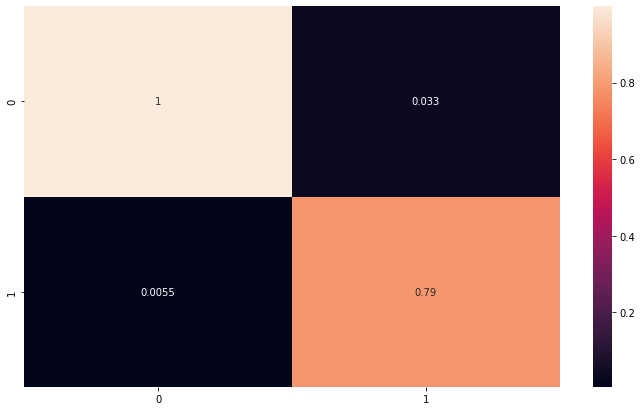

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = ['0','1'],
                     columns = ['0','1'])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
y_pred = []
y_true = []
sigmoid = nn.Sigmoid()
for X1_batch, X2_batch, y_batch in val_loader:
        #print("w.requires_grad:",X_batch.requires_grad)
        X1_batch, X2_batch, y_batch = X1_batch.to(device), X2_batch.to(device), y_batch.to(device)
        y_batch_pred = torch.round(sigmoid(loaded_model(X1_batch.float(), X2_batch.float())))
        y_pred.extend(y_batch_pred.cpu().detach().numpy())
        y_true.extend(y_batch.cpu().detach().numpy())

In [ ]:
#Val Dataset
count_true = 0
for i in range(len(y_pred)):
  if y_true[i]==y_pred[i]:
    count_true+=1
acc = count_true/len(y_pred)
print(len(y_test))
print(acc)

2424
0.9935838680109991


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
(tn, fp, fn, tp)

(2132, 2, 12, 36)

**ML Explanations**

In [ ]:
i = 0
for X1_batch, X2_batch, y_batch in train_loader:
  if i==0:
    print(type(X1_batch))
    train_X1 = X1_batch
    train_X2 = X2_batch
    i = 1
  else:
    train_X1 = np.concatenate((train_X1, X1_batch), axis=0)
    train_X2 = np.concatenate((train_X2, X2_batch), axis=0)

X1_train = torch.from_numpy(train_X1)
X2_train = torch.from_numpy(train_X2)
X1_train = X1_train.to(device)
X2_train = X2_train.to(device)
print(X1_train.shape)
print(type(X1_train))
print(X2_train.shape)
print(type(X2_train))

<class 'torch.Tensor'>
torch.Size([19632, 108, 7])
<class 'torch.Tensor'>
torch.Size([19632, 100, 5])
<class 'torch.Tensor'>


In [ ]:
i = 0
for X1_batch, X2_batch, y_batch in test_loader:
  if i==0:
    print(type(X1_batch))
    test_X1 = X1_batch
    test_X2 = X2_batch
    i = 1
  else:
    test_X1 = np.concatenate((test_X1, X1_batch), axis=0)
    test_X2 = np.concatenate((test_X2, X2_batch), axis=0)

X1_test = torch.from_numpy(test_X1)
X2_test = torch.from_numpy(test_X2)
X1_test = X1_test.to(device)
X2_test = X2_test.to(device)
print(X1_test.shape)
print(type(X1_test))
print(X2_test.shape)
print(type(X2_test))

<class 'torch.Tensor'>
torch.Size([2424, 108, 7])
<class 'torch.Tensor'>
torch.Size([2424, 100, 5])
<class 'torch.Tensor'>


In [ ]:
import gc

In [ ]:

del train_loader
gc.collect()
del test_loader
gc.collect()
del val_loader
gc.collect()

0

**IG**

In [ ]:
!pip install captum
from captum.attr import IntegratedGradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.6 MB/s eta 0:00:00


In [ ]:
ig = IntegratedGradients(loaded_model)

In [ ]:
def prediction(x1, x2):
  sigmoid = nn.Sigmoid()
  x1 = torch.reshape(x1, (1, x1.shape[0], x1.shape[1]))
  x2 = torch.reshape(x2, (1, x2.shape[0], x2.shape[1]))
  val = sigmoid(loaded_model(x1.float(), x2.float()))
  print(val)

In [ ]:
def predict_n_step(x1, x2, n):
  sigmoid = nn.Sigmoid()
  for i in range(n,108):
    x1[i] = [0,0,0,0,0,0,0]
  x1 = torch.from_numpy(x1).to(device)
  x1 = torch.reshape(x1, (1, x1.shape[0], x1.shape[1]))
  x2 = torch.reshape(x2, (1, x2.shape[0], x2.shape[1]))
  val = sigmoid(loaded_model(x1.float(), x2.float()))
  print(val)

In [ ]:
def generate_ig(x1, x2):
  sample_1 = torch.reshape(x1, (1, x1.shape[0], x1.shape[1]))
  sample_2 = torch.reshape(x2, (1, x2.shape[0], x2.shape[1]))
  baseline1 = torch.zeros(sample_1.shape[0], sample_1.shape[1], sample_1.shape[2]).to(device)
  baseline2 = torch.zeros(sample_2.shape[0], sample_2.shape[1], sample_2.shape[2]).to(device)
  attributions, approximation_error = ig.attribute((sample_1.float(), sample_2.float()),
                                                 baselines=(baseline1, baseline2),
                                                 method='gausslegendre',
                                                 return_convergence_delta=True)
  return attributions[0].cpu().numpy().reshape(108,7), attributions[1].cpu().numpy().reshape(100,5)

In [ ]:
def eth_aggregated_values(attr):
  #features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_addresses', 'Gene_Coefficient', 'Avg_Gas']
  aggregated = [0,0,0,0,0,0,0]
  for arr in attr:
    abs_sum = 0
    for val in arr:
      abs_sum += abs(val)
    if abs_sum==0:
      continue
    for i in range(len(arr)):
      aggregated[i] += arr[i]/abs_sum
  #print(aggregated)
  return aggregated

def sent_aggregated_values(attr):
  #features = ['V_Neg', 'Neg', 'Neutral', 'Pos', 'V_Pos']
  aggregated = [0,0,0,0,0]
  for arr in attr:
    abs_sum = 0
    for val in arr:
      abs_sum += abs(val)
    if abs_sum==0:
      continue
    for i in range(len(arr)):
      aggregated[i] += arr[i]/abs_sum
  #print(aggregated)
  agg_sum = 0
  for val in aggregated:
    agg_sum += val
  return agg_sum

def plot_features(attr, sent):
  attr.append(sent)
  attr = list(map(lambda x: x/abs(max(attr, key=abs)), attr))
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas', 'Sentiment']
  pos = np.arange(len(features))
  colors = ['g' if e >= 0 else 'r' for e in attr]

  plt.barh(pos,attr,color=colors,edgecolor='black')
  plt.yticks(pos, features)
  plt.xlabel('Aggregated IG', fontsize=16)
  plt.ylabel('features', fontsize=16)
  plt.title('Integrated Gradients',fontsize=20)
  plt.show()

In [ ]:
def gradient_all(attr):
  max_int = abs(max(list(np.reshape(attr, (108*7))), key=abs))
  fig = plt.figure(figsize = (20, 5))
  x = np.array([i for i in range(1,109)])
  plt.xticks([i for i in range(1,109,2)])
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gini_Coef', 'Avg_Gas']

  for i in range(7):
    col = []
    for j in range(108):
      col.append(abs(attr[j][i]))
    #col = list(map(lambda x: x/max_int, col))
    #col = list(map(lambda x_: x_/abs(max(col, key=abs)), col))
    plt.xticks([i for i in range(1,109,2)])
    plt.plot(x, col)

  #lt.rc('font', size=10)
  #plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
  #plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
  #plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
  #plt.rc('legend', fontsize=12)    # legend fontsize
  #plt.rc('figure', titlesize=20)  # fontsize of the figure title
  plt.xlabel("Timesteps", fontsize=16)
  plt.ylabel("Integrated gradient", fontsize=16)
  #plt.title("Gradients of all features", fontsize=14)
  plt.legend(features, fontsize=16)
  plt.savefig('gradient_all_healthy.pdf', dpi=1200, bbox_inches='tight')
  plt.show()

  # fig = plt.figure(figsize = (20, 5))
  # for i in range(7):
  #   col = []
  #   for j in range(108):
  #     col.append(abs(attr[j][i]))
  #   col = list(map(lambda x: x/max_int, col))
  #   #col = list(map(lambda x_: x_/abs(max(col, key=abs)), col))
  #   plt.xticks([i for i in range(1,109,2)])
  #   plt.plot(x, col)

  # #plt.rc('legend', fontsize=12)    # legend fontsize
  # #plt.rc('figure', titlesize=20)  # fontsize of the figure title
  # plt.xlabel("Timesteps", fontsize=14)
  # plt.ylabel("Value", fontsize=14)
  # plt.title("Gradients of all features - Normalized", fontsize=14)
  # plt.legend(features, fontsize=14)
  # plt.savefig('gradient_norm.svg', dpi=1200, pad_inches=0)
  # plt.show()

In [ ]:
def scatter_all(attr, vals):
  max_int = abs(max(list(np.reshape(attr, (108*7))), key=abs))
  fig = plt.figure(figsize = (20, 5))
  x = np.array([i for i in range(1,109)])
  plt.xticks([i for i in range(1,109,2)])
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  colours = ['Reds_r', 'Blues_r', 'Greens_r', 'Oranges_r', 'Greys_r', 'Purples_r', 'pink_r']

  for i in range(7):
    fea = []
    col = []
    for j in range(108):
      fea.append(vals[j][i])
      col.append(abs(attr[j][i]))
    fea = list(map(lambda x: x/abs(max(fea, key=abs)), fea))
    col = list(map(lambda x: x/max_int, col))
    plt.scatter(x, fea, c=col, cmap=colours[i])

  plt.xlabel("Timesteps")
  plt.ylabel("Value")
  plt.title("Importance of all features")
  plt.legend(features)
  ##
  #pdf.savefig(fig)
  #pdf.close()
  plt.show()


In [ ]:
def scatter_feature(attr, vals, feature):
  fig = plt.figure(figsize = (20, 5))
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f_index = features.index(feature)
  y = []
  for arr in vals:
    y.append(arr[f_index])
  y = list(map(lambda x_: x_/abs(max(y, key=abs)), y))
  y = np.array(y)
  x = np.array([i for i in range(1,109)])
  colors = []
  for arr in attr:
    colors.append(arr[f_index])
  colors = list(map(lambda x_: x_/abs(max(colors, key=abs)), colors))
  colors = np.array(colors)
  plt.scatter(x, y, c=colors, cmap='Reds_r')
  plt.colorbar()
  plt.xlabel("Timesteps")
  plt.ylabel("Value")
  plt.title("Importance of "+feature)
  plt.legend([feature])
  plt.show()

In [ ]:
def scatter_feature2(attr, vals, feature1, feature2):
  ##
  #pdf = PdfPages('scatter.pdf')
  #fig = plt.figure(figsize = (20, 5))
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f1_index = features.index(feature1)
  y = []
  for arr in vals:
    y.append(arr[f1_index])
  y = list(map(lambda x_: x_/abs(max(y, key=abs)), y))
  y = np.array(y)
  x = np.array([i for i in range(1,109)])
  colors = []
  for arr in attr:
    colors.append(arr[f1_index])
  colors = list(map(lambda x_: x_/abs(max(colors, key=abs)), colors))
  colors = np.array(colors)
  plt.xticks([i for i in range(1,109,2)])
  plt.scatter(x, y, c=colors, cmap='Reds_r')

  f2_index = features.index(feature2)
  y = []
  for arr in vals:
    y.append(arr[f2_index])
  y = list(map(lambda x_: x_/abs(max(y, key=abs)), y))
  y = np.array(y)
  x = np.array([i for i in range(1,109)])
  colors = []
  for arr in attr:
    colors.append(arr[f2_index])
  colors = list(map(lambda x_: x_/abs(max(colors, key=abs)), colors))
  colors = np.array(colors)/255
  plt.xticks([i for i in range(1,109,2)])
  plt.scatter(x, y, c=colors, cmap='Blues_r')

  plt.xlabel("Timesteps")
  plt.ylabel("Value")
  plt.title("Importance of "+feature1+" and " + feature2)
  plt.legend([feature1, feature2])
  ##
  #pdf.savefig(fig)
  #pdf.close()
  plt.show()

In [ ]:
def line_plot(attr, vals, feature):
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f_index = features.index(feature)
  steps = [i for i in range(1,109)]
  values = []
  fig = plt.figure(figsize = (20, 5))
  for arr in vals:
    values.append(arr[f_index])
  #values = list(map(lambda x: x/abs(max(values, key=abs)), values))
  plt.plot(steps, values, color='red')
  plt.xlabel("Timesteps")
  plt.ylabel("Value")
  plt.title("Values of "+feature)
  plt.xticks([i for i in range(1,109,2)])
  plt.show()

  fig = plt.figure(figsize = (20, 5))
  values2 = []
  for arr in attr:
    values2.append(arr[f_index])
  #values2 = list(map(lambda x: x/abs(max(values2, key=abs)), values2))
  plt.plot(steps, values2, color='blue')
  plt.xlabel("Timesteps")
  plt.ylabel("IG Value")
  plt.title("IG of "+feature)
  plt.xticks([i for i in range(1,109,2)])
  plt.show()

In [ ]:
def scatter_subplot(attr, vals, feature1, feature2):
  ##
  #pdf = PdfPages('scatter.pdf')
  fig = plt.figure(figsize = (20, 5))
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f1_index = features.index(feature1)
  y1 = []
  for arr in vals:
    y1.append(arr[f1_index])
  y1 = list(map(lambda x_: x_/abs(max(y1, key=abs)), y1))
  y1 = np.array(y1)
  x = np.array([i for i in range(1,109)])
  colors1 = []
  for arr in attr:
    colors1.append(arr[f1_index])
  colors1 = list(map(lambda x_: x_/abs(max(colors1, key=abs)), colors1))
  colors1 = np.array(colors1)

  f2_index = features.index(feature2)
  y2 = []
  for arr in vals:
    y2.append(arr[f2_index])
  y2 = list(map(lambda x_: x_/abs(max(y2, key=abs)), y2))
  y2 = np.array(y2)
  colors2 = []
  for arr in attr:
    colors2.append(arr[f2_index])
  colors2 = list(map(lambda x_: x_/abs(max(colors2, key=abs)), colors2))
  colors2 = np.array(colors2)
  plt.xticks([i for i in range(1,109,2)])

  ax1 = plt.subplot()
  l1 = ax1.scatter(x, y1, c=colors1, cmap='Reds_r')
  ax2 = ax1.twinx()
  l2 = ax2.scatter(x, y2, c=colors2, cmap='Blues_r')
  ax1.set_ylabel(feature1)
  ax2.set_ylabel(feature2)
  plt.legend([l1, l2], [feature1, feature2])
  plt.title("Importance of "+feature1+" , "+feature2)
  plt.xticks([i for i in range(1,109,2)])
  ##
  #pdf.savefig(fig)
  #pdf.close()
  plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
def value_gradient(attr, vals, feature):
  ##
  #pdf = PdfPages('line_plot.pdf')
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f_index = features.index(feature)
  steps = [i for i in range(1,109)]
  fig = plt.figure(figsize = (20, 5))
  values = []
  for arr in vals:
    values.append(arr[f_index])
  grad_vals = []
  for arr in attr:
    grad_vals.append(arr[f_index])

  ax1 = plt.subplot()
  l1, = ax1.plot(steps, values, color='red')
  ax2 = ax1.twinx()
  l2, = ax2.plot(steps, grad_vals, color='blue')
  ax1.set_ylabel("Block difference", fontsize=16)
  ax2.set_ylabel("IG of Block difference", fontsize=16)
  ax2.set_xlabel("Timesteps")
  plt.legend([l1, l2], ["Value", "IG"], fontsize=16)
  plt.xlabel("Timesteps")
  #plt.title("Importance of "+feature)
  plt.xticks([i for i in range(1,109,2)])
  ##
  plt.savefig('val_grad_scam_u.pdf', dpi=1200, bbox_inches='tight')
  #pdf.close()
  plt.show()

In [ ]:
def sentiment_value_gradient(attr, vals):
  steps = [i for i in range(1,101)]
  fig = plt.figure(figsize = (20, 5))
  values = []
  grad_vals = []
  for i in range(attr.shape[0]):
    max_v = vals[i].argmax()
    values.append(max_v/4)
    max_g = np.abs(attr[i]).argmax()
    grad_vals.append(max_g/4)
    #grad_vals.append(abs(attr[i][max_i]))
  ax1 = plt.subplot()
  l1, = ax1.plot(steps, values, color='red')
  ax2 = ax1.twinx()
  l2, = ax2.plot(steps, grad_vals, color='blue')
  ax1.set_ylabel("Value")
  ax2.set_ylabel("IG Value")
  plt.legend([l1, l2], ["Feature_Value", "IG_Value"])
  plt.title("Importance of Sentiments")
  plt.xticks([i for i in range(1,101,2)])
  plt.show()

In [ ]:
def scatter_sentiment_grad(attr, vals):
  #pdf1 = PdfPages('sentiment_v.pdf')
  #pdf2 = PdfPages('sentiment_g.pdf')
  fig = plt.figure(figsize = (20, 5))
  plt.xticks([i for i in range(1,101,2)])
  x = np.array([i for i in range(1,101)])
  values_i = []
  values = []
  grad_i = []
  grad_vals = []
  for i in range(attr.shape[0]):
    max_v = vals[i].argmax()
    values_i.append(max_v/4)
    values.append(vals[i][max_v])
    max_g = np.abs(attr[i]).argmax()
    grad_i.append(max_g/4)
    grad_vals.append(attr[i][max_g])
  values = list(map(lambda x_: x_/abs(max(values, key=abs)), values))
  grad_vals = list(map(lambda x_: x_/abs(max(grad_vals, key=abs)), grad_vals))
  plt.scatter(x, values, s=75, c=values_i, cmap='Reds', linewidths=0.4, edgecolors='black')
  #plt.colorbar()
  plt.xlabel("Timesteps", fontsize=16)
  plt.ylabel("Sentiment value", fontsize=16)
  #plt.title("Values of Sentiment", fontsize=16)
  plt.legend(["Value"], fontsize=14)
  #pdf1.savefig(fig, dpi=1200)
  plt.savefig('sentiment_vals.pdf', dpi=1200, bbox_inches='tight')
  plt.show()

  fig = plt.figure(figsize = (20, 5))
  plt.xticks([i for i in range(1,101,2)])
  plt.scatter(x, grad_vals, s=75, c=grad_i, cmap='Blues', linewidths=0.4, edgecolors='black')
  #plt.colorbar()
  plt.xlabel("Timesteps", fontsize=16)
  plt.ylabel("Integrated Gradient", fontsize=16)
  #plt.title("Importance of Sentiment", fontsize=14)
  plt.legend(["IG Value"], fontsize=16)
  #pdf2.savefig(fig, dpi=1200)
  #pdf1.close()
  #pdf2.close()
  plt.savefig('sentiment_grad.pdf', dpi=1200, bbox_inches='tight')
  plt.show()

In [ ]:
def sentiment_line_scatter(attr, vals):
  fig = plt.figure(figsize = (20, 5))
  plt.xticks([i for i in range(1,101,2)])
  x = np.array([i for i in range(1,101)])
  values_i = []
  values = []
  grad_vals = []
  for i in range(attr.shape[0]):
    max_v = vals[i].argmax()
    values_i.append(max_v/4)
    values.append(vals[i][max_v])
    grad_vals.append(attr[i][max_v])

  plt.xticks([i for i in range(1,101,2)])
  plt.scatter(x, values, c=values_i, cmap='Blues_r')
  plt.xticks([i for i in range(1,109,2)])
  plt.plot(x, grad_vals, color='red')
  plt.xlabel("Timesteps")
  plt.ylabel("Value")
  plt.title("Importance of Sentiment")
  plt.legend(["Sentiment", "IG value"])
  #pdf2.savefig(fig, dpi=1200)
  #pdf1.close()
  #pdf2.close()
  plt.savefig('Figure4.svg', dpi=1200, pad_inches=0)
  plt.show()


**Scam Examples**

In [ ]:
neg_index = 1056
# - 1056, 123, 481
#gas - 671
#sent - 57, 70, 179, 190, 193, 363, 380, 398, 495, 553
#vol, mint, burn - 277, 349, 456
#495 - Gene, Avg_Gas
#ex: 179, 190
index = neg_index # 1 pos, 4 neg
prediction(X1_test[index], X2_test[index])

tensor([[0.0007]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
eth_attr, sent_attr = generate_ig(X1_test[index], X2_test[index])
print(eth_attr.shape)
print(sent_attr.shape)

(108, 7)
(100, 5)


In [ ]:
predict_n_step(X1_test[index].cpu().numpy(), X2_test[index], 92)

tensor([[0.0206]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
predict_n_step(X1_test[index].cpu().numpy(), X2_test[index], 93)

tensor([[0.0003]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
predict_n_step(X1_test[index].cpu().numpy(), X2_test[index], 94)

tensor([[0.0007]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
#import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 5})

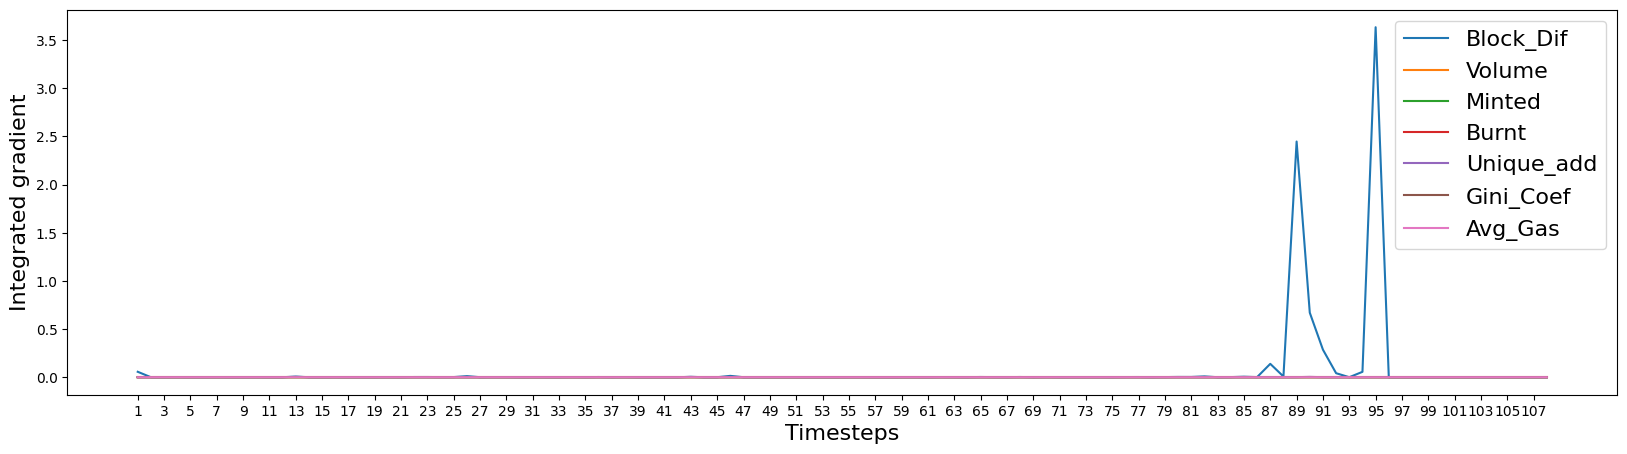

In [ ]:
gradient_all(eth_attr)

In [ ]:
scatter_all(eth_attr, X1_test[index].cpu().numpy())

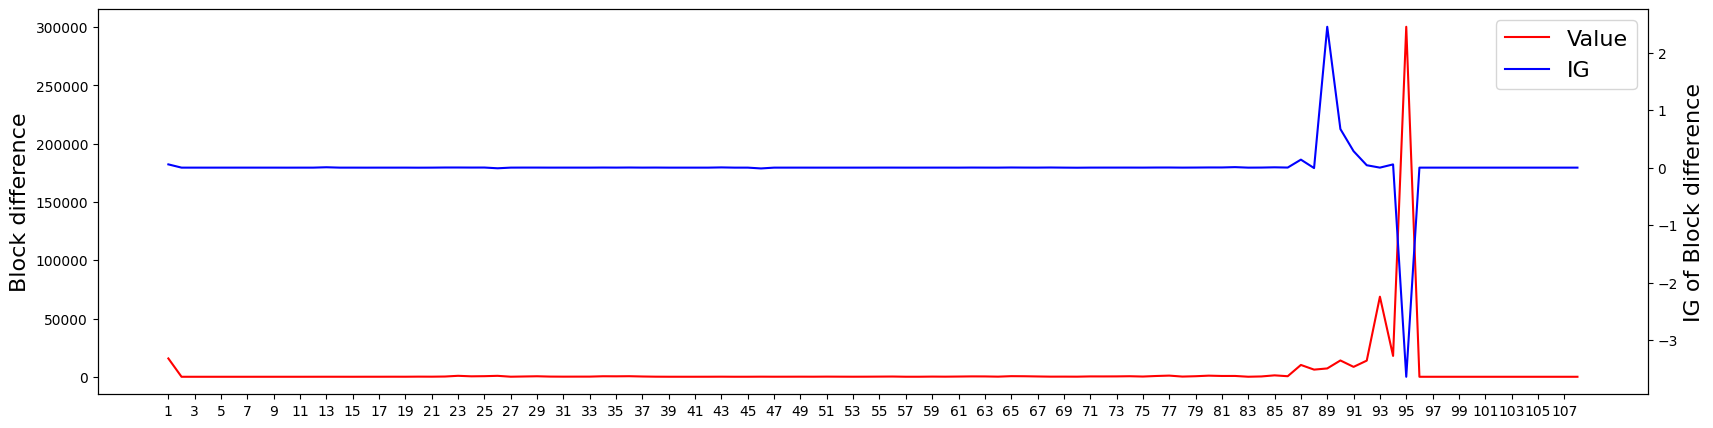

In [ ]:
value_gradient(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif')

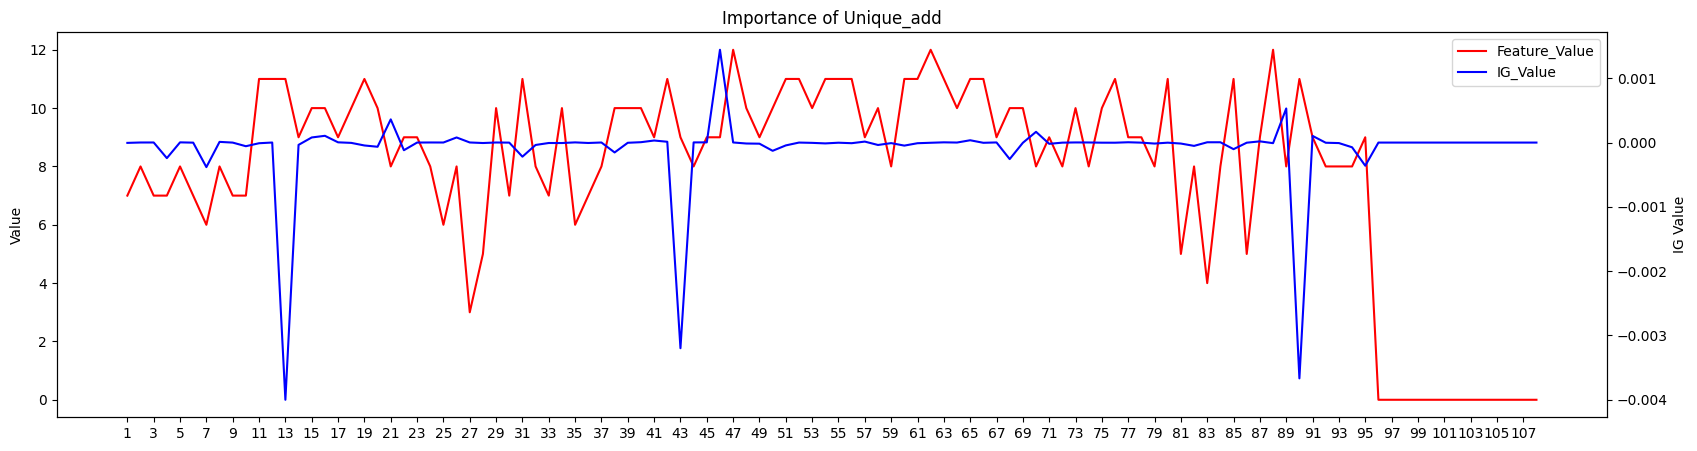

In [ ]:
value_gradient(eth_attr, X1_test[index].cpu().numpy(), 'Unique_add')

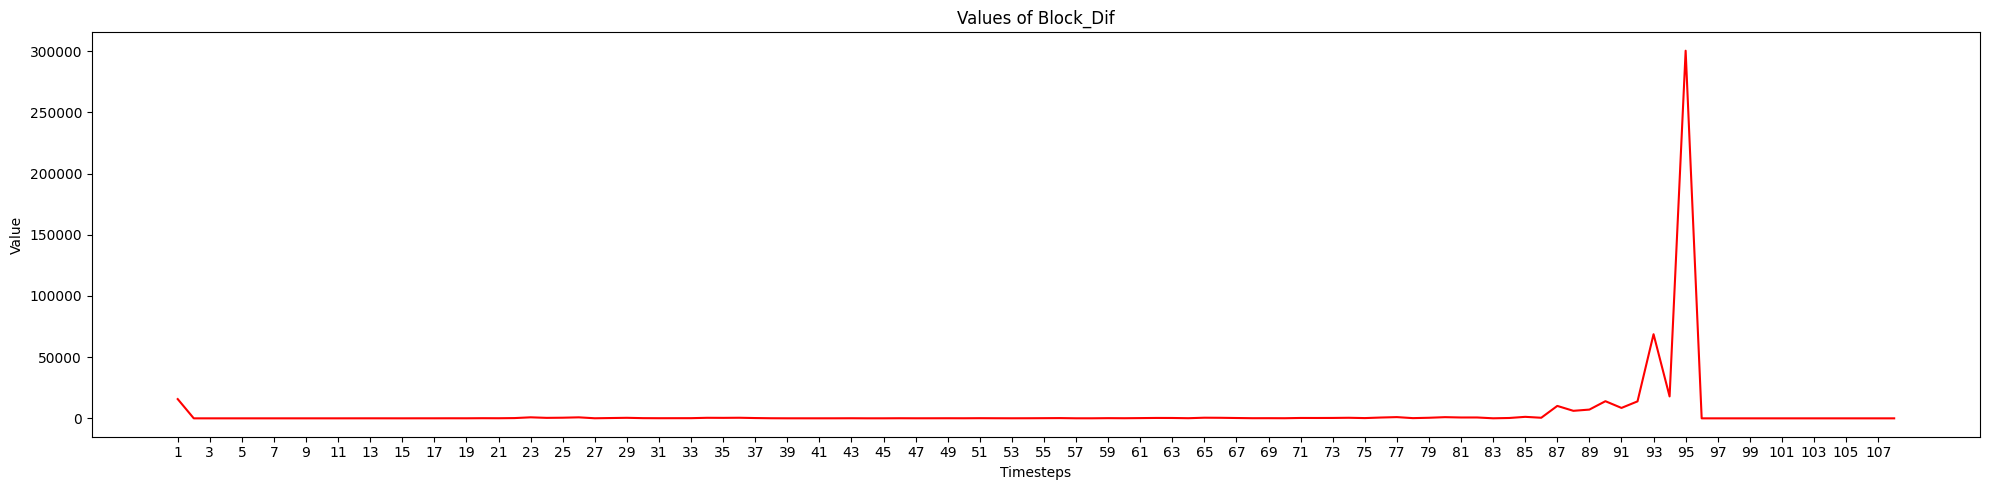

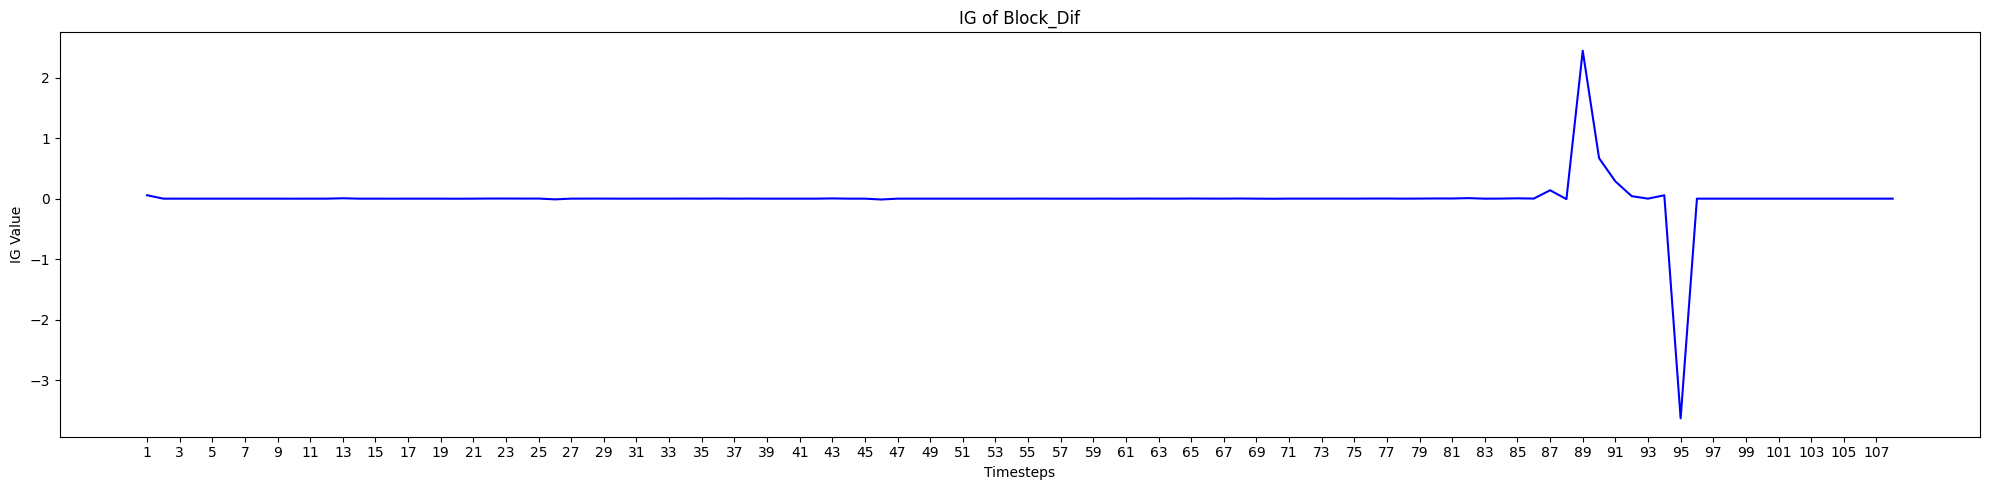

In [ ]:
line_plot(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif')

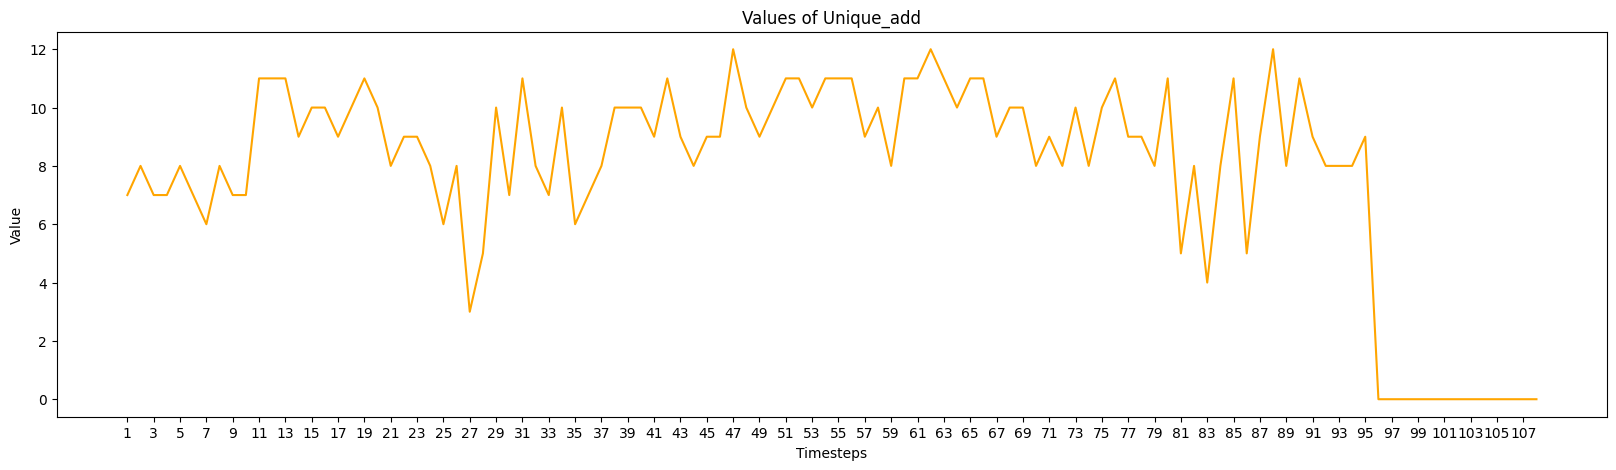

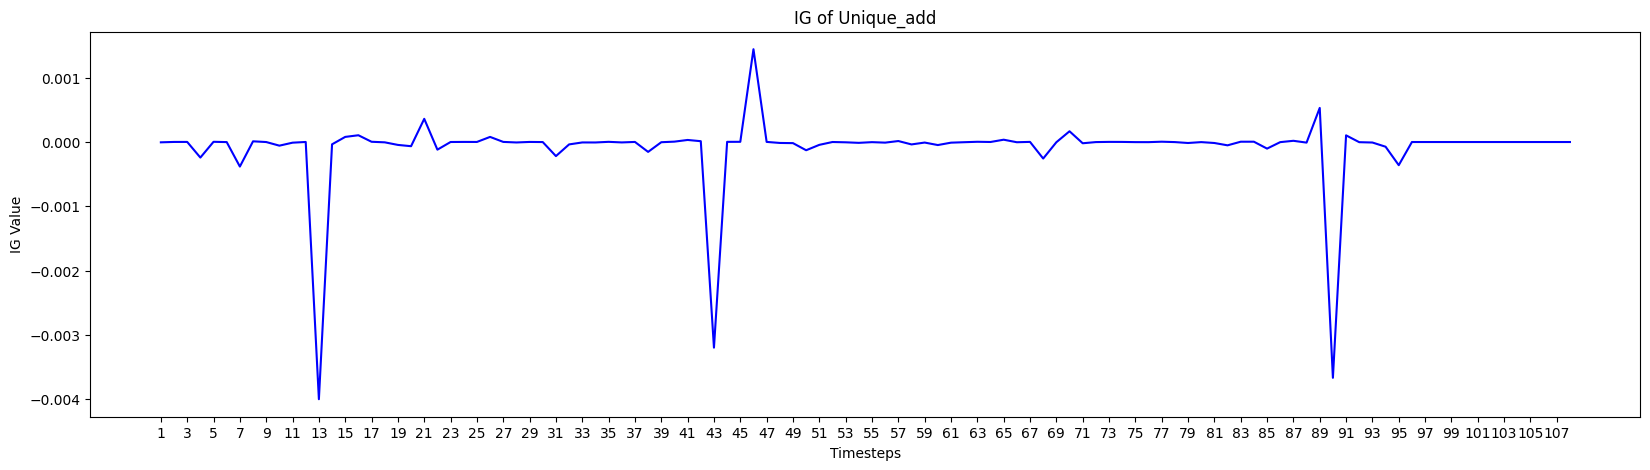

In [ ]:
line_plot(eth_attr, X1_test[index].cpu().numpy(), 'Unique_add')

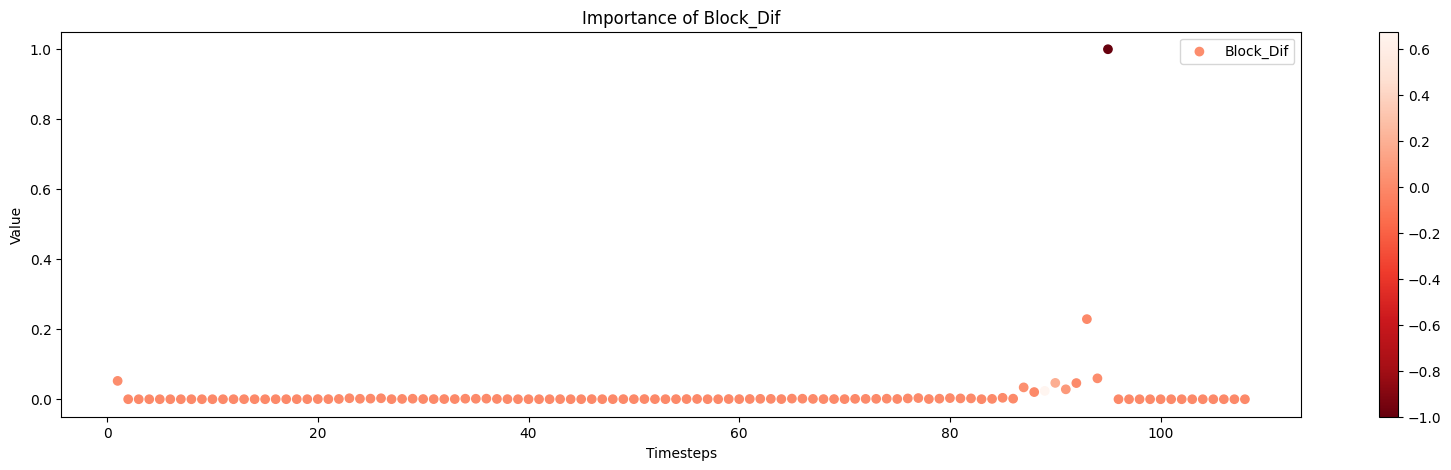

In [ ]:
scatter_feature(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif')

In [ ]:
scatter_feature2(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif', 'Unique_add')

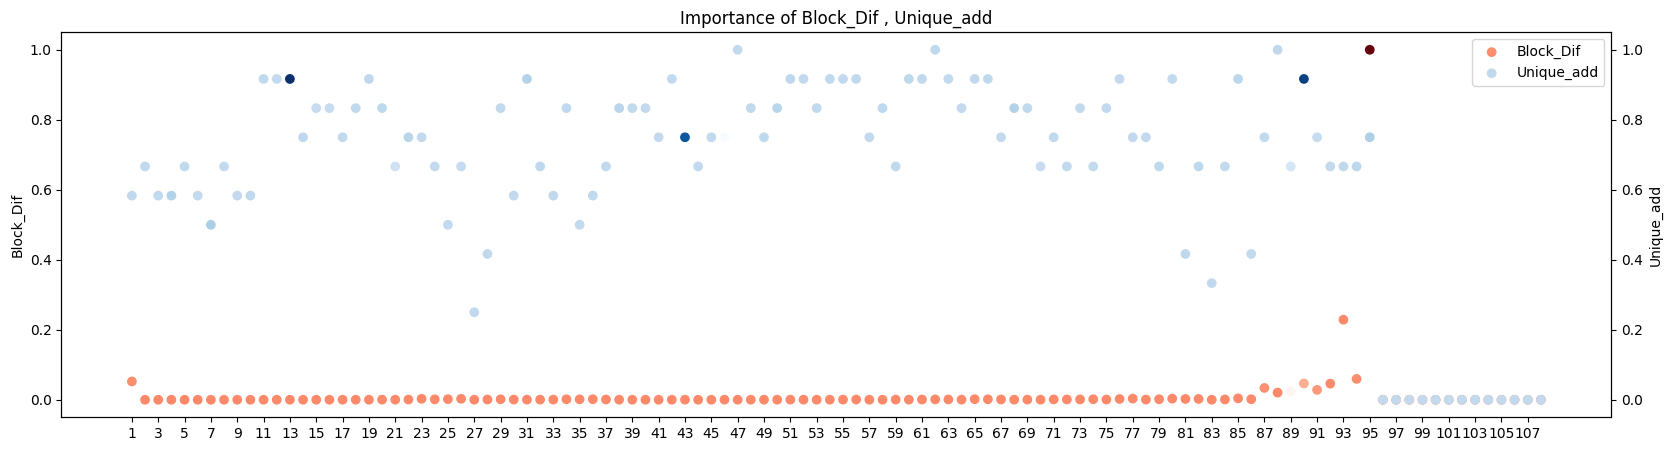

In [ ]:
scatter_subplot(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif', 'Unique_add')

In [ ]:
neg_index = 495
#features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
#gas - 671
#495 - Gene, Avg_Gas
index = neg_index # 1 pos, 4 neg
prediction(X1_test[index], X2_test[index])

tensor([[0.0029]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
eth_attr, sent_attr = generate_ig(X1_test[index], X2_test[index])
print(eth_attr.shape)
print(sent_attr.shape)

(108, 7)
(100, 5)


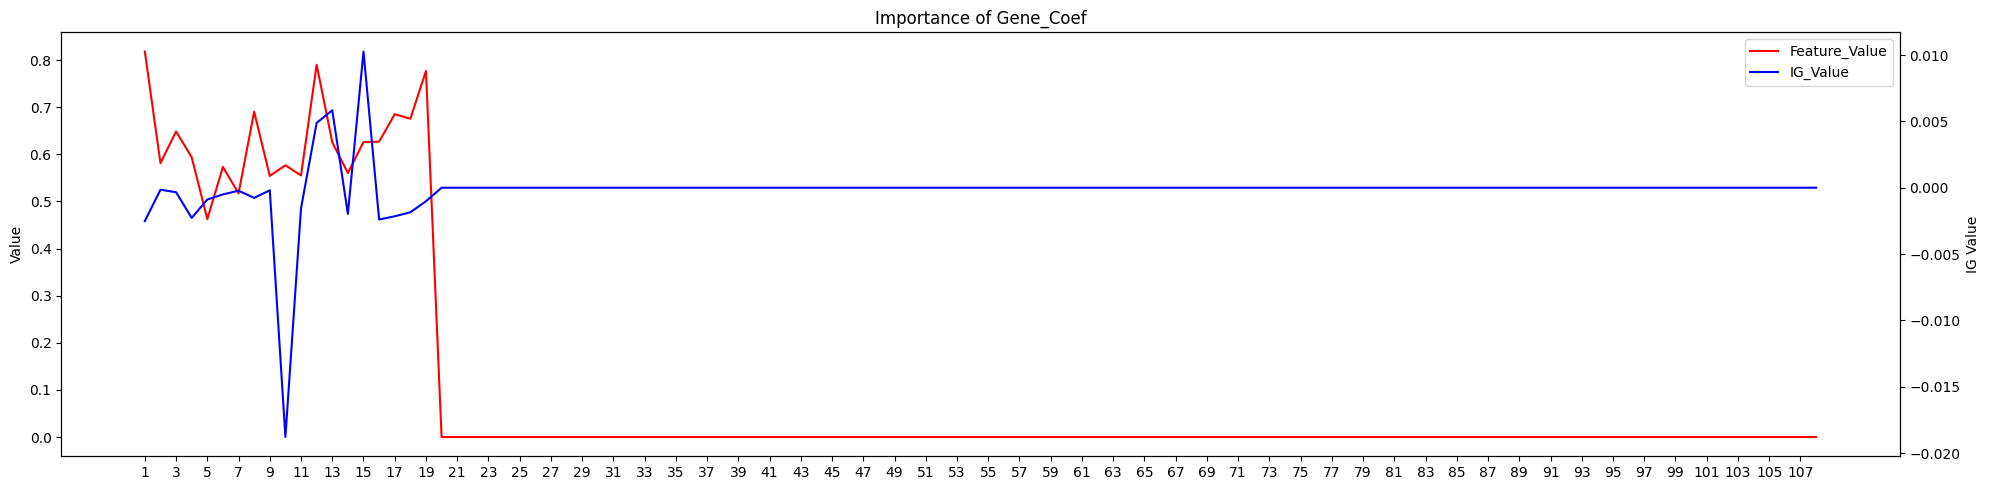

In [ ]:
value_gradient(eth_attr, X1_test[index].cpu().numpy(), 'Gene_Coef')

**Trustworthy Examples**

In [ ]:
pos_index = 545
# - 545
# - 2008
index = pos_index
prediction(X1_test[index], X2_test[index])

tensor([[0.9369]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
eth_attr, sent_attr = generate_ig(X1_test[index], X2_test[index])
print(eth_attr.shape)
print(sent_attr.shape)

(108, 7)
(100, 5)


In [ ]:
predict_n_step(X1_test[index].cpu().numpy(), X2_test[index], 90)

tensor([[0.7908]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
predict_n_step(X1_test[index].cpu().numpy(), X2_test[index], 91)

tensor([[0.7859]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
predict_n_step(X1_test[index].cpu().numpy(), X2_test[index], 97)

tensor([[0.8605]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
predict_n_step(X1_test[index].cpu().numpy(), X2_test[index], 98)

tensor([[0.8799]], device='cuda:0', grad_fn=<SigmoidBackward0>)


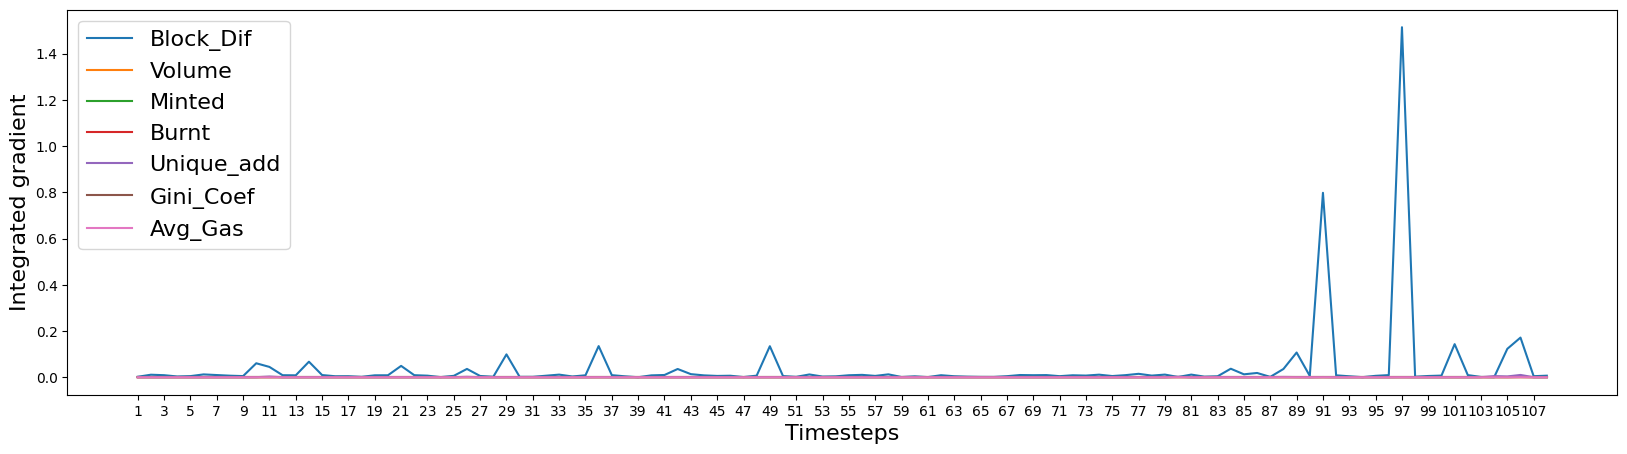

In [ ]:
gradient_all(eth_attr)

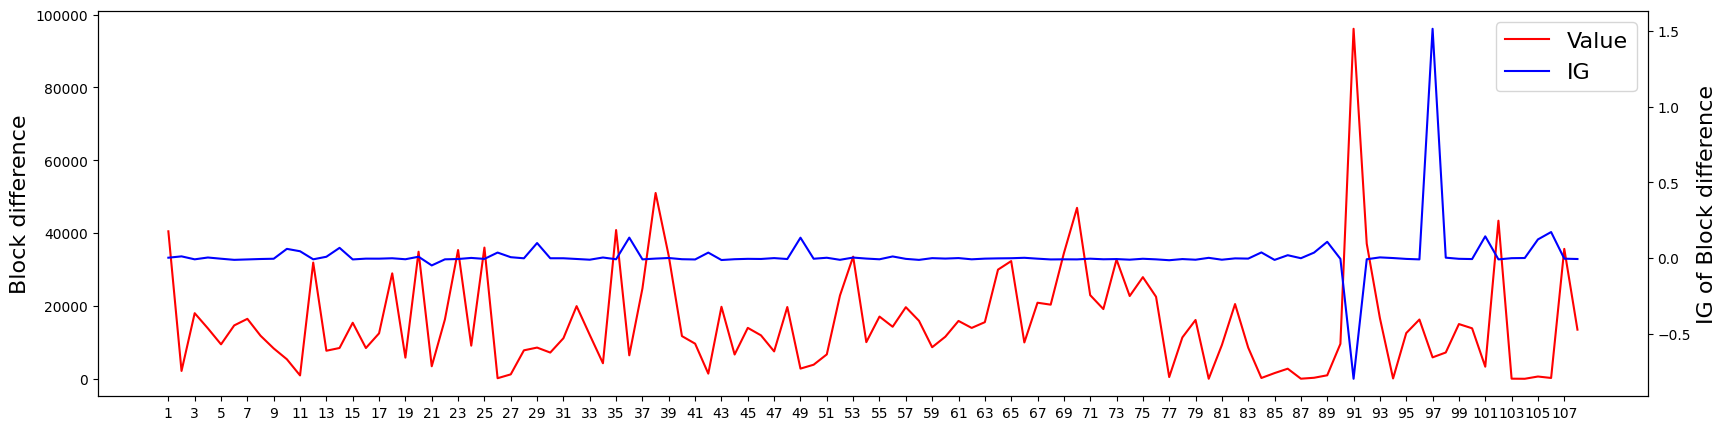

In [ ]:
value_gradient(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif')

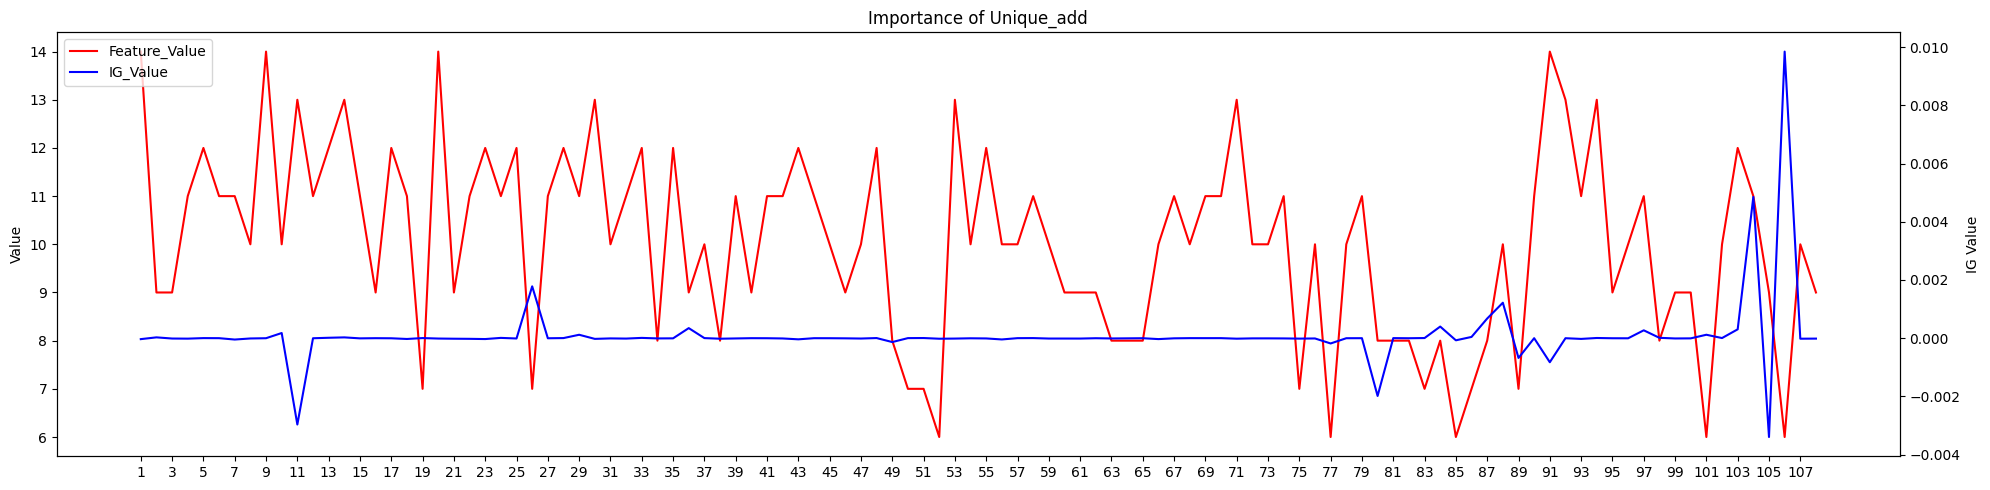

In [ ]:
value_gradient(eth_attr, X1_test[index].cpu().numpy(), 'Unique_add')

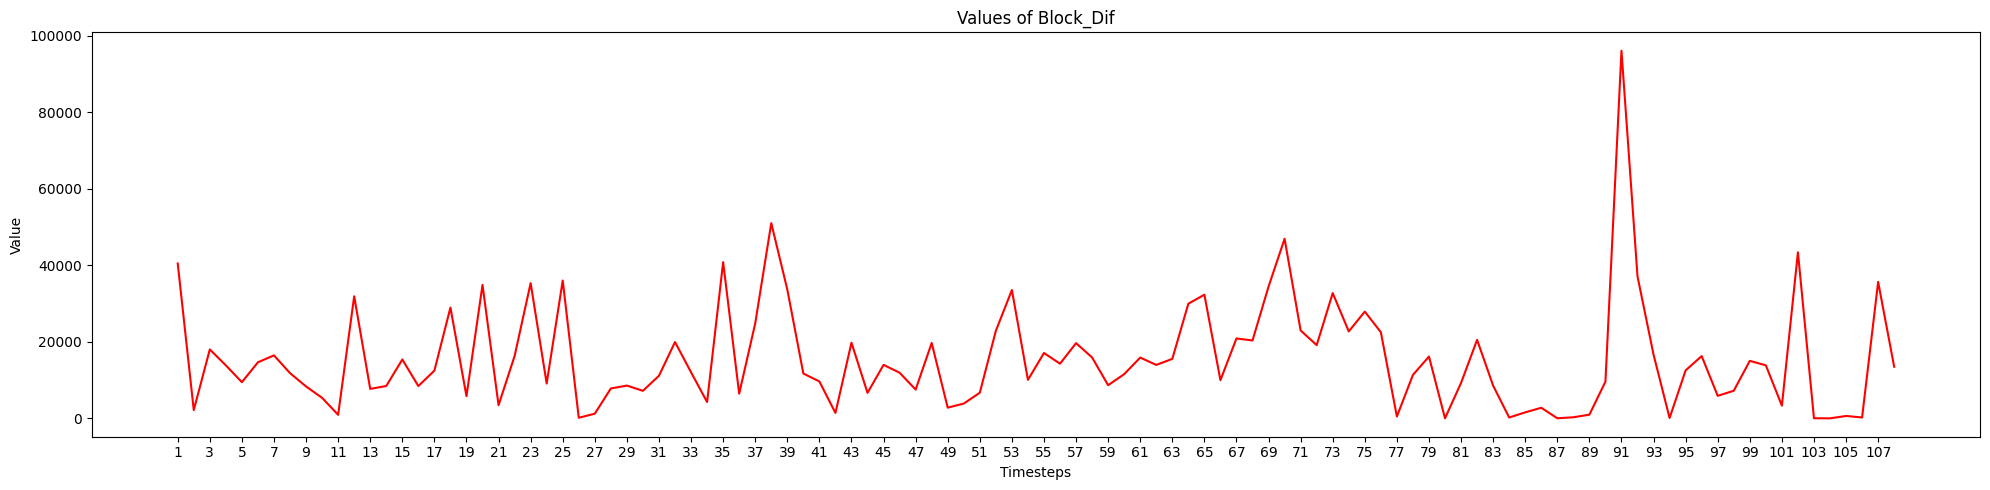

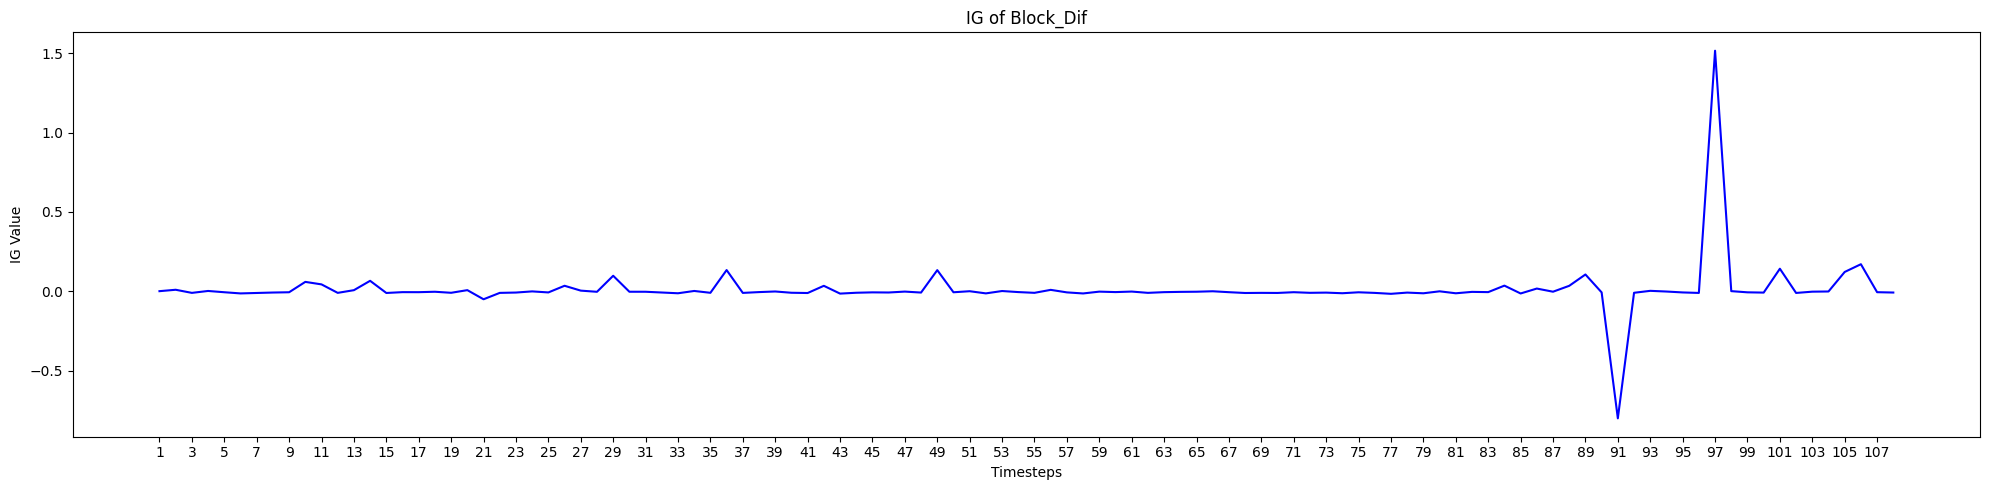

In [ ]:
line_plot(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif')

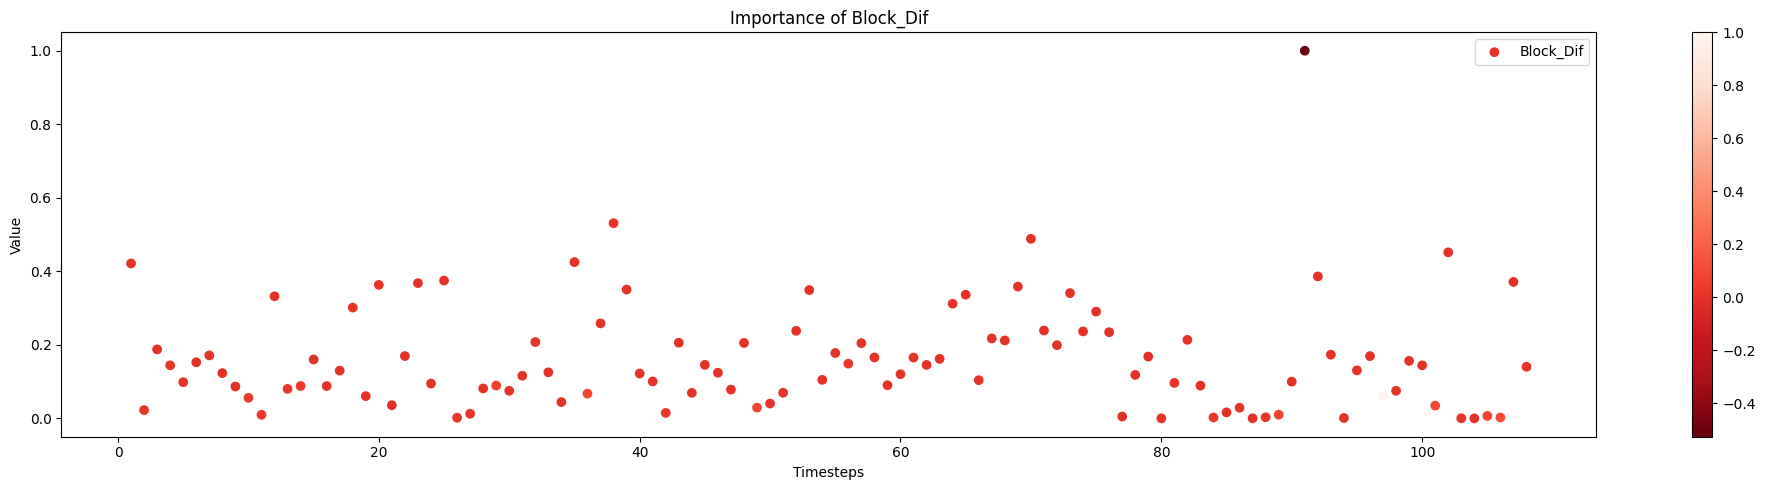

In [ ]:
scatter_feature(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif')

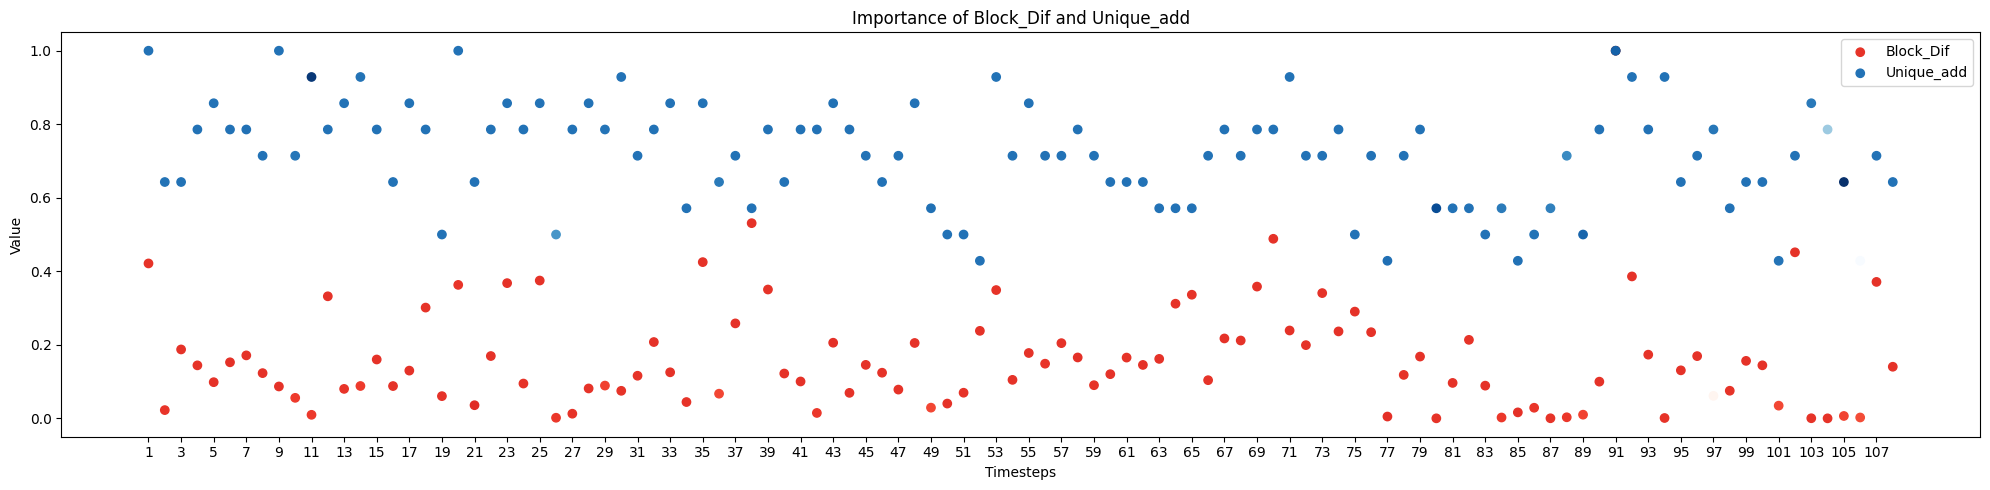

In [ ]:
scatter_feature2(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif', 'Unique_add')

**Sentiment - Scam**

In [ ]:
neg_index = 205
# - 99, 113, 128, 193, 205
index = neg_index
prediction(X1_test[index], X2_test[index])

tensor([[0.0148]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
eth_attr, sent_attr = generate_ig(X1_test[index], X2_test[index])
print(eth_attr.shape)
print(sent_attr.shape)

(108, 7)
(100, 5)


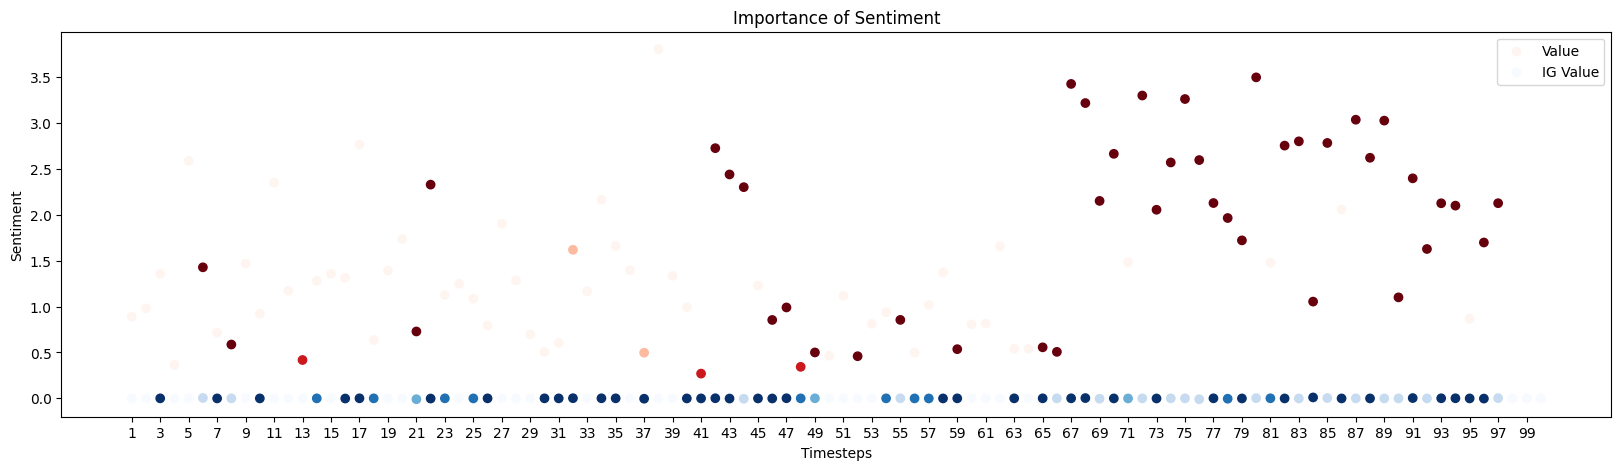

In [ ]:
scatter_sentiment_grad(sent_attr, X2_test[index].cpu().numpy())

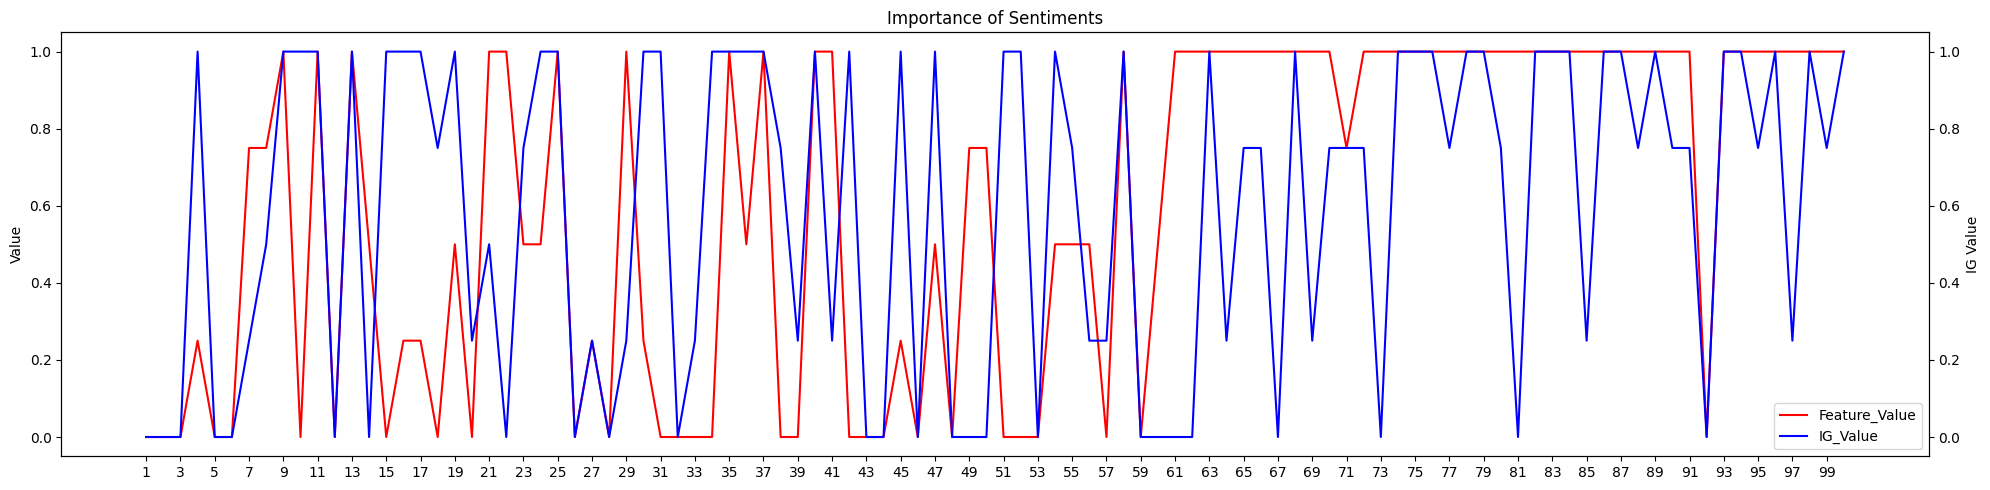

In [ ]:
sentiment_value_gradient(sent_attr, X2_test[index].cpu().numpy())

**Sentiment - Trustworthy**

In [ ]:
pos_index = 2025
# - 770, 1397
#sent - 136, 324, 411, 574, 1044, 1123, 952, 1899, 1946, 935, 2008, 246
# 757, 770, 947, 1122, 1192, 1397, 1609, 1697, 1789, 1928, 2025, 2091, 2278
index = pos_index
prediction(X1_test[index], X2_test[index])

tensor([[0.9382]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
#delete this
exmp_scam = X1_test[index].cpu().detach().numpy()
lis = []
for ar in exmp_scam:
  lis.append(ar[0])
ndar = np.array(lis)
print(ndar)
np.save("exmp_sent_2025.npy",ndar)

In [ ]:
eth_attr, sent_attr = generate_ig(X1_test[index], X2_test[index])
print(eth_attr.shape)
print(sent_attr.shape)

(108, 7)
(100, 5)


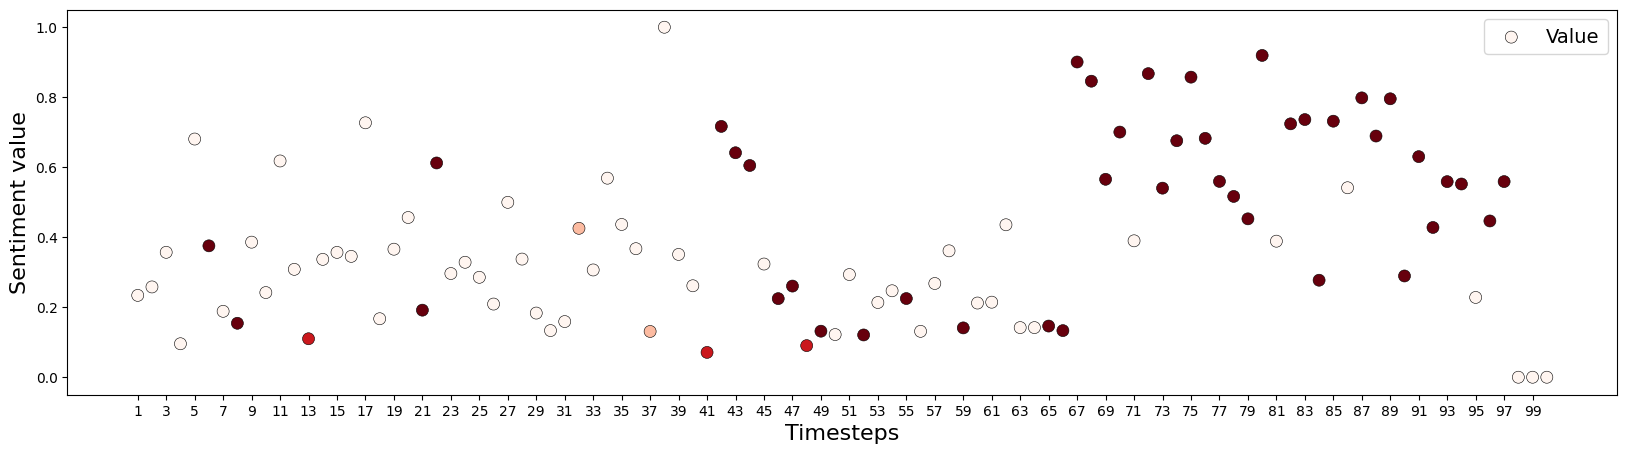

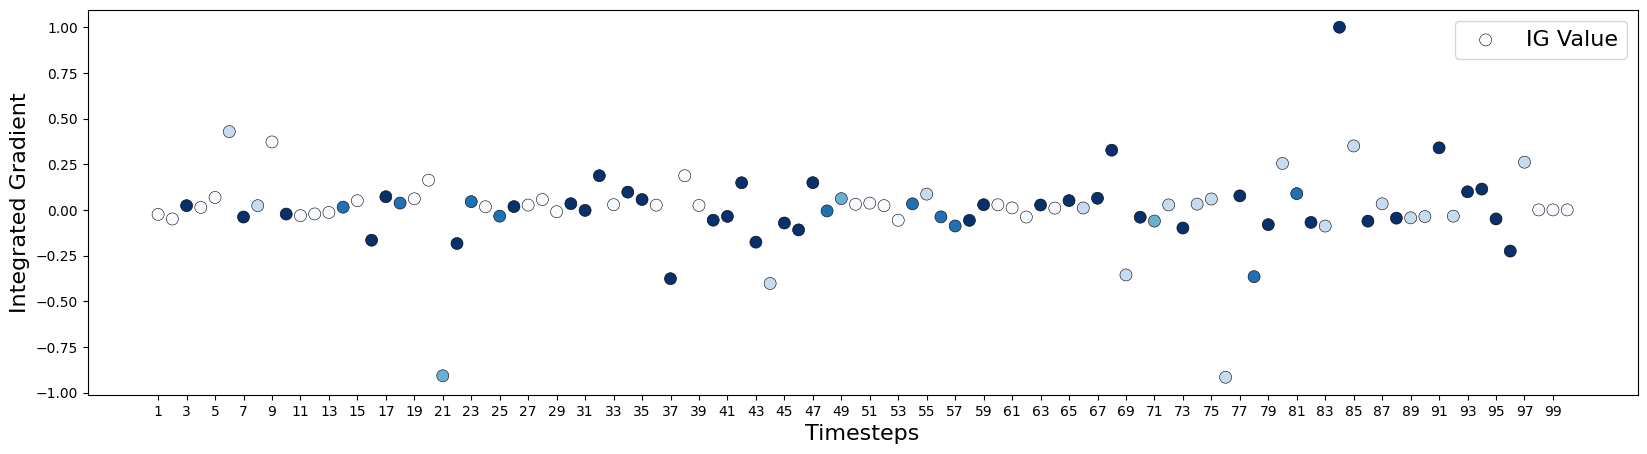

In [ ]:
scatter_sentiment_grad(sent_attr, X2_test[index].cpu().numpy())

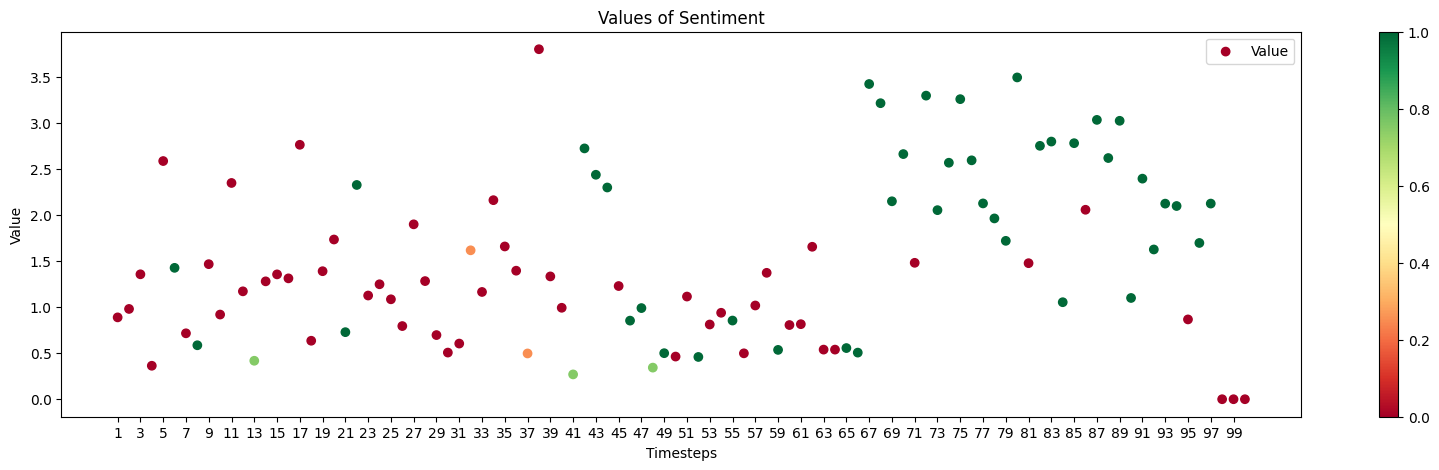

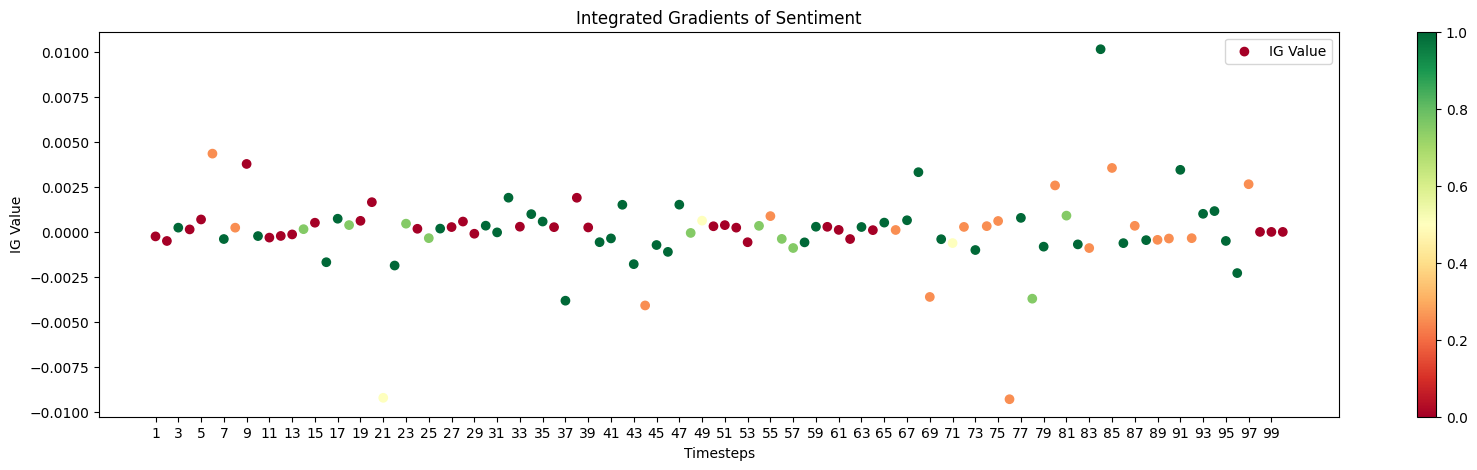

In [ ]:
scatter_sentiment_grad(sent_attr, X2_test[index].cpu().numpy())

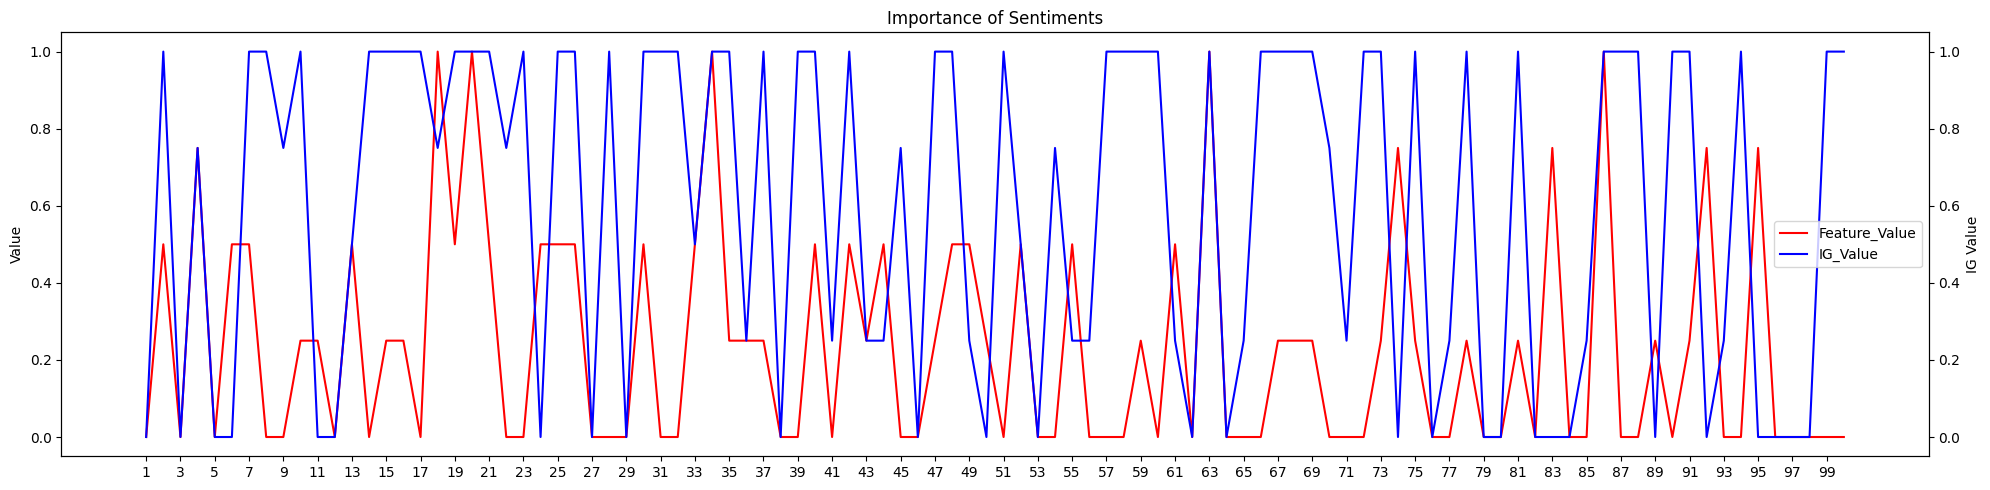

In [ ]:
sentiment_value_gradient(sent_attr, X2_test[index].cpu().numpy())

**Tests**

In [ ]:
def plot_timeline(attr, feature):
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas', 'Sentiment']
  f_index = features.index(feature)
  steps = [i for i in range(1,109)]
  values = []
  fig = plt.figure(figsize = (20, 5))
  for arr in attr:
    values.append(arr[f_index])
  colors = ['g' if e >= 0 else 'r' for e in values]
  plt.bar(steps, values, color =colors,
        width = 0.4)
  plt.xlabel("Timesteps")
  plt.ylabel("IG value")
  plt.title("Importance of "+feature)
  plt.show()

In [ ]:
def plot_val_timeline(vals, feature):
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f_index = features.index(feature)
  steps = [i for i in range(1,109)]
  values = []
  fig = plt.figure(figsize = (20, 5))
  for arr in vals:
    values.append(arr[f_index])
  colors = ['g' if e >= 0 else 'r' for e in values]
  plt.bar(steps, values, color =colors,
        width = 0.4)
  plt.xlabel("Timesteps")
  plt.ylabel("Values")
  plt.title("Change of "+feature)
  plt.show()

In [ ]:
def line_plot(attr, vals, feature):
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f_index = features.index(feature)
  steps = [i for i in range(1,109)]
  values = []
  fig = plt.figure(figsize = (20, 5))
  for arr in attr:
    values.append(arr[f_index])
  values = list(map(lambda x: x/abs(max(values, key=abs)), values))
  plt.plot(steps, values, color='orange')
  plt.xlabel("Timesteps")
  plt.ylabel("Value/IG value")
  plt.title("Importance of "+feature)

  values2 = []
  for arr in vals:
    values2.append(arr[f_index])
  values2 = list(map(lambda x: x/abs(max(values2, key=abs)), values2))
  plt.plot(steps, values2, color='blue')
  plt.legend(['IG','Values'])

  plt.show()

In [ ]:
def line_plot2(attr, vals, feature1, feature2):
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f1_index = features.index(feature1)
  steps = [i for i in range(1,109)]
  values = []
  fig = plt.figure(figsize = (20, 5))
  for arr in attr:
    values.append(arr[f1_index])
  values = list(map(lambda x: x/abs(max(values, key=abs)), values))
  plt.plot(steps, values, color='orange')
  plt.xlabel("Timesteps")
  plt.ylabel("Value/IG value")
  plt.title("Importance of "+feature1+" and " + feature2)

  values2 = []
  for arr in vals:
    values2.append(arr[f1_index])
  values2 = list(map(lambda x: x/abs(max(values2, key=abs)), values2))
  plt.plot(steps, values2, color='blue')

  f2_index = features.index(feature2)
  values3 = []
  for arr in attr:
    values3.append(arr[f2_index])
  values3 = list(map(lambda x: x/abs(max(values3, key=abs)), values3))
  plt.plot(steps, values3, color='red')

  values4 = []
  for arr in vals:
    values4.append(arr[f2_index])
  values4 = list(map(lambda x: x/abs(max(values4, key=abs)), values4))
  plt.plot(steps, values4, color='green')
  plt.legend(['IG-'+feature1, feature1, 'IG-'+feature2, feature2])

  plt.show()

In [ ]:
def line_plot2_p(attr, vals, feature1, feature2):
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f1_index = features.index(feature1)
  steps = [i for i in range(1,26)]
  values = []
  fig = plt.figure(figsize = (20, 5))
  for arr in attr:
    values.append(arr[f1_index])
  values = list(map(lambda x: x/abs(max(values, key=abs)), values))
  values = values[:25]
  plt.plot(steps, values, color='orange')
  plt.xlabel("Timesteps")
  plt.ylabel("Value/IG value")
  plt.title("Importance of "+feature1+" and " + feature2)

  values2 = []
  for arr in vals:
    values2.append(arr[f1_index])
  values2 = list(map(lambda x: x/abs(max(values2, key=abs)), values2))
  values2 = values2[:25]
  plt.plot(steps, values2, color='blue')

  f2_index = features.index(feature2)
  values3 = []
  for arr in attr:
    values3.append(arr[f2_index])
  values3 = list(map(lambda x: x/abs(max(values3, key=abs)), values3))
  values3 = values3[:25]
  plt.plot(steps, values3, color='red')

  values4 = []
  for arr in vals:
    values4.append(arr[f2_index])
  values4 = list(map(lambda x: x/abs(max(values4, key=abs)), values4))
  values4 = values4[:25]
  plt.plot(steps, values4, color='green')
  plt.legend(['IG-'+feature1, feature1, 'IG-'+feature2, feature2])

  plt.show()

In [ ]:
def plot_sentiment_vals(data):
  #features = ['V_Neg', 'Neg', 'Neutral', 'Pos', 'V_Pos']
  steps = [i for i in range(1,101)]
  sentiments = []
  values = []
  fig = plt.figure(figsize = (20, 5))
  for i in range(data.shape[0]):
    max_i = data[i].argmax()
    sentiments.append(max_i/4)
    values.append(data[i][max_i])
  colors = ['g' if e >= 0.5 else 'r' for e in sentiments]
  plt.bar(steps, values, color =colors,
        width = 0.4)
  plt.xlabel("Timesteps")
  plt.ylabel("Values")
  plt.title("Change of Sentiments")
  plt.show()

In [ ]:
def plot_sentiment_timeline(attr, data):
  #features = ['V_Neg', 'Neg', 'Neutral', 'Pos', 'V_Pos']
  steps = [i for i in range(1,101)]
  values = []
  values2 = []
  fig = plt.figure(figsize = (20, 5))
  for i in range(attr.shape[0]):
    max_i = data[i].argmax()
    values2.append(max_i/4)
    sum = 0
    for j in range(attr.shape[1]):
      sum += attr[i][j]*data[i][j]
    values.append(sum)
  values = list(map(lambda x: x/abs(max(values, key=abs)), values))
  plt.plot(steps, values, color='orange')
  plt.xlabel("Timesteps")
  plt.ylabel("Sentiment Positivity/IG value")
  plt.title("Importance of sentiments")
  plt.plot(steps, values2, color='blue')
  plt.legend(['IG','Values'])
  plt.show()

'''
  #features = ['V_Neg', 'Neg', 'Neutral', 'Pos', 'V_Pos']
  steps = [i for i in range(1,101)]
  values = []
  values2 = []
  fig = plt.figure(figsize = (20, 5))
  for i in range(attr.shape[0]):
    max_i = data[i].argmax()
    values2.append(max_i/4)
    values.append(attr[i][max_i])
  values = list(map(lambda x: x/abs(max(values, key=abs)), values))
  plt.plot(steps, values, color='orange')
  plt.xlabel("Timesteps")
  plt.ylabel("Sentiment Positivity/IG value")
  plt.title("Importance of sentiments")
  plt.plot(steps, values2, color='blue')
  plt.legend(['IG','Values'])
  plt.show()
'''
'''
  for arr in attr:
    values.append(sum(arr))
  values = list(map(lambda x: x/abs(max(values, key=abs)), values))
  plt.plot(steps, values, color='orange')
  plt.xlabel("Timesteps")
  plt.ylabel("Sentiment Positivity/IG value")
  plt.title("Importance of sentiments")

  values2 = []
  for arr in data:
    values2.append(arr.argmax()/4)
  plt.plot(steps, values2, color='blue')
  plt.legend(['IG','Values'])

  plt.show()
'''

'\n  for arr in attr:\n    values.append(sum(arr))\n  values = list(map(lambda x: x/abs(max(values, key=abs)), values))\n  plt.plot(steps, values, color=\'orange\')\n  plt.xlabel("Timesteps")\n  plt.ylabel("Sentiment Positivity/IG value")\n  plt.title("Importance of sentiments")\n\n  values2 = []\n  for arr in data:\n    values2.append(arr.argmax()/4)\n  plt.plot(steps, values2, color=\'blue\')\n  plt.legend([\'IG\',\'Values\'])\n\n  plt.show()\n'

In [ ]:
vals = X1_test[0].cpu().numpy()
print(vals[0])

[141.           1.           1.           0.           8.
   0.5801931    0.90651446]


**Scam Tokens**

In [ ]:
neg_index = 190
#sent - 57, 70, 179, 190, 193, 363, 380, 398, 495, 553
#vol, mint, burn - 277, 349, 456
#495 - Gene, Avg_Gas
#ex: 179, 190

In [ ]:
index = neg_index # 1 pos, 4 neg
prediction(X1_test[index], X2_test[index])



tensor([[0.0003]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
eth_attr, sent_attr = generate_ig(X1_test[index], X2_test[index])
print(eth_attr.shape)
print(sent_attr.shape)

(108, 7)
(100, 5)


In [ ]:
eth_agg = eth_aggregated_values(eth_attr)

In [ ]:
sent_agg = sent_aggregated_values(sent_attr)

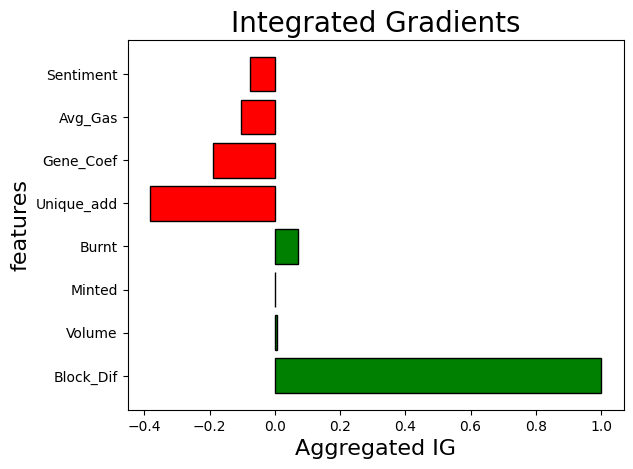

In [ ]:
plot_features(eth_agg, sent_agg)

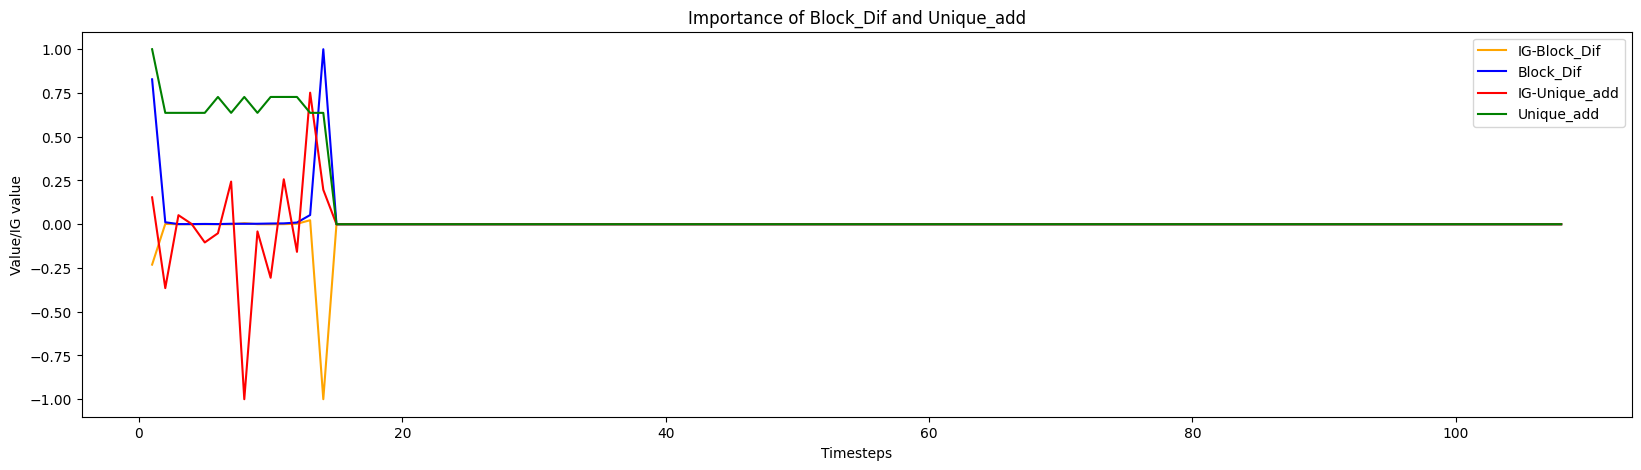

In [ ]:
line_plot2(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif','Unique_add')

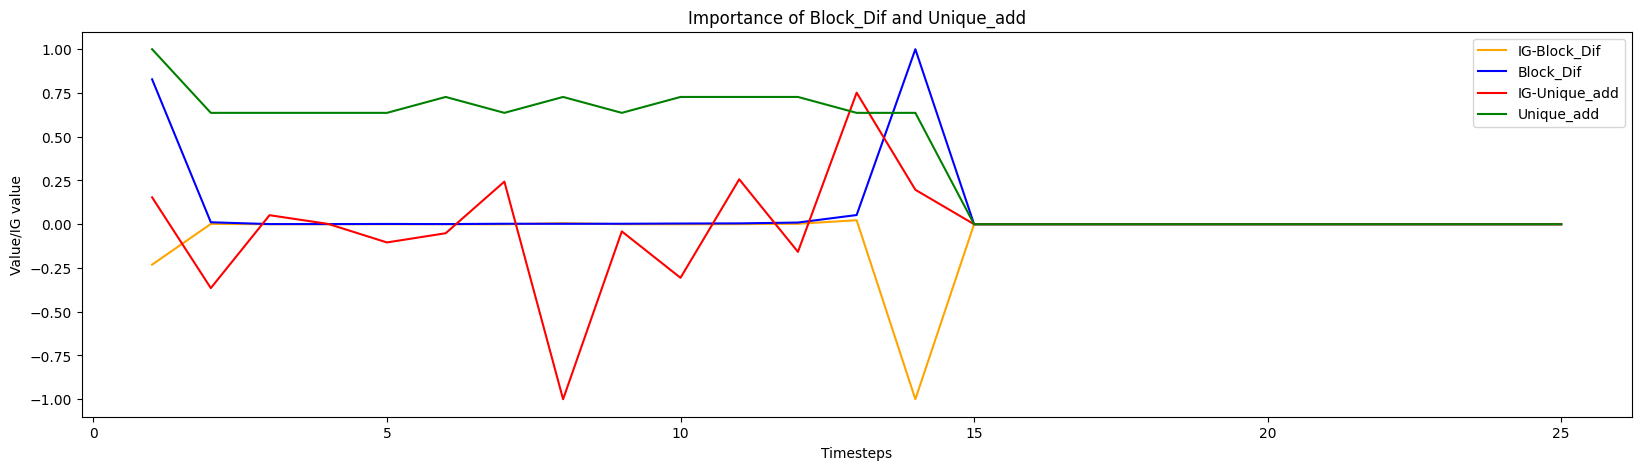

In [ ]:
line_plot2_p(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif','Unique_add')

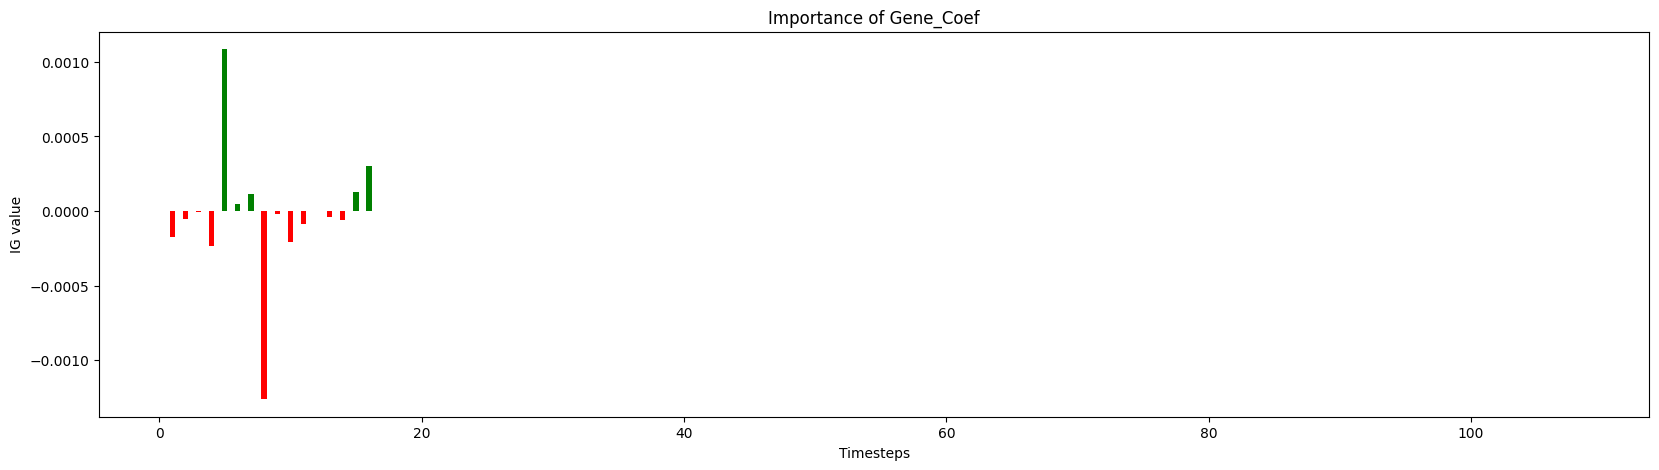

In [ ]:
plot_timeline(eth_attr, 'Gene_Coef')

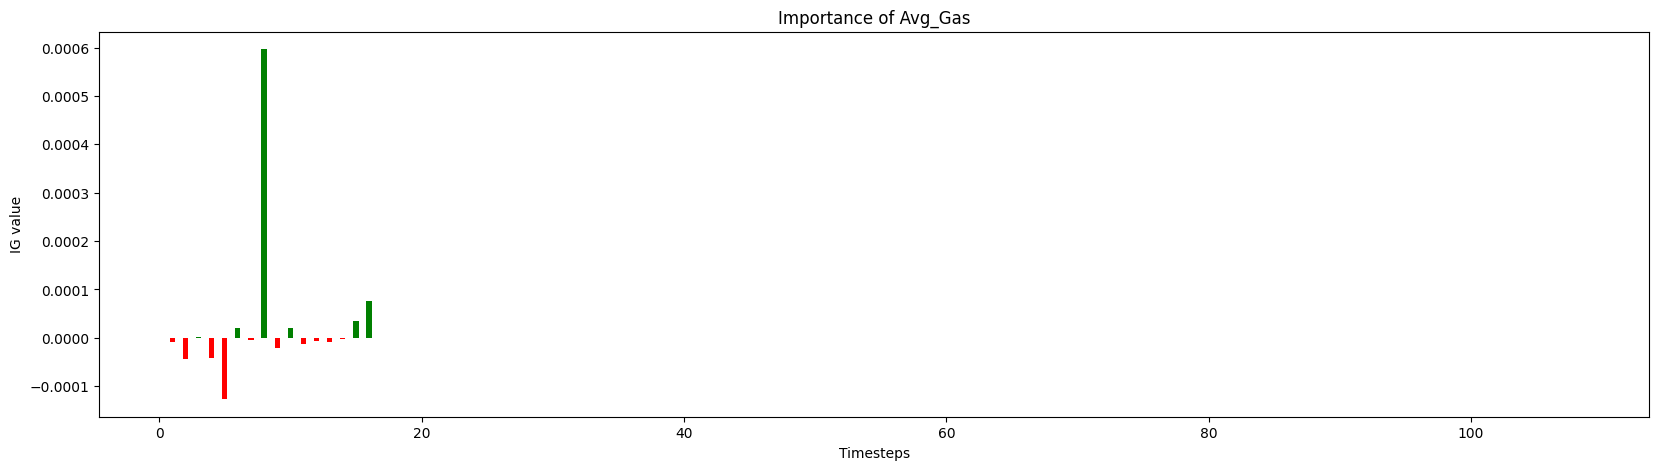

In [ ]:
plot_timeline(eth_attr, 'Avg_Gas')

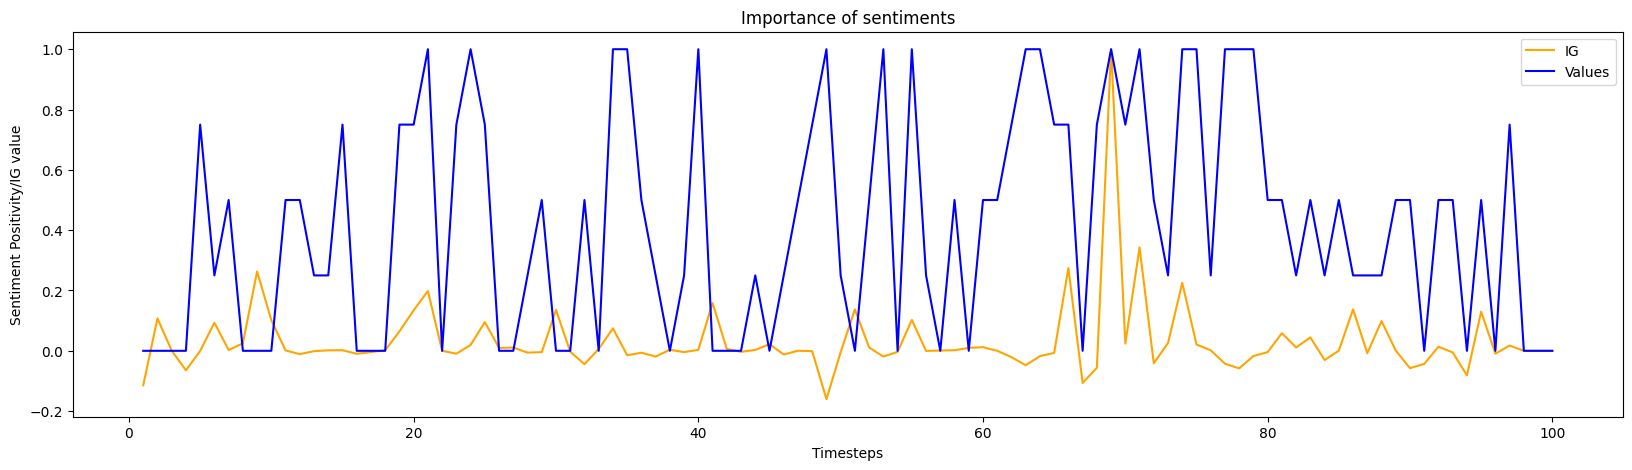

In [ ]:
plot_sentiment_timeline(sent_attr, X2_test[index].cpu().numpy())

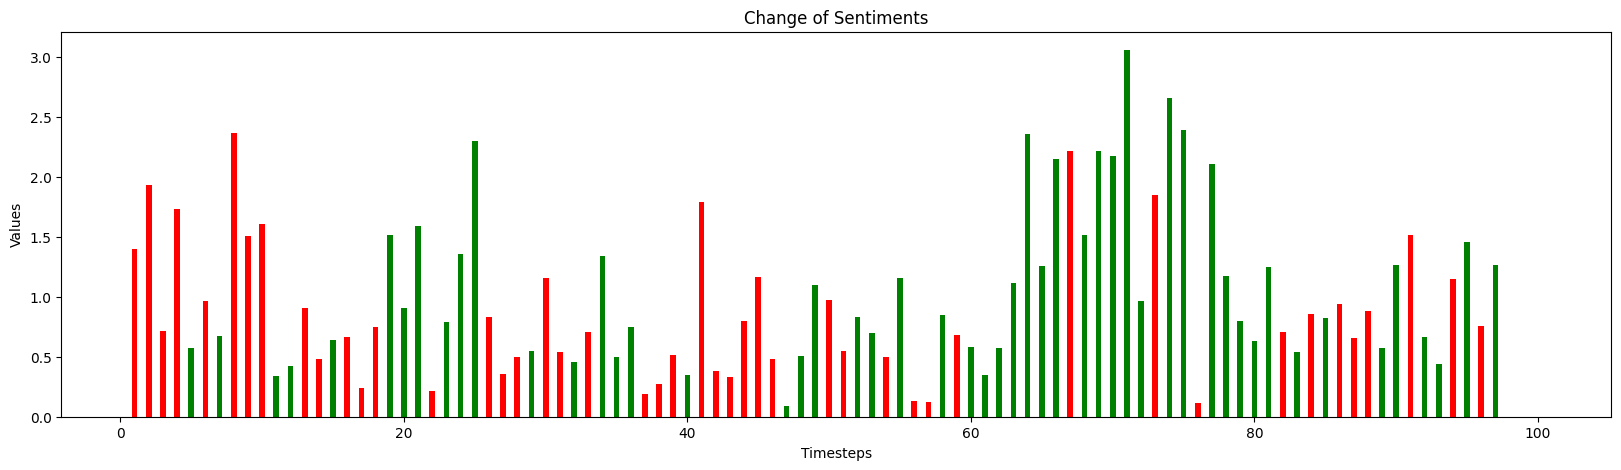

In [ ]:
plot_sentiment_vals(X2_test[index].cpu().numpy())

In [ ]:
def scatter_feature(attr, vals, feature):
  fig = plt.figure(figsize = (20, 5))
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f_index = features.index(feature)
  y = []
  for arr in vals:
    y.append(arr[f_index])
  y = list(map(lambda x_: x_/abs(max(y, key=abs)), y))
  y = np.array(y)
  x = np.array([i for i in range(1,109)])
  colors = []
  for arr in attr:
    colors.append(arr[f_index])
  colors = list(map(lambda x_: x_/abs(max(colors, key=abs)), colors))
  colors = np.array(colors)
  plt.scatter(x, y, c=colors, cmap='Reds')
  plt.colorbar()
  plt.show()

In [ ]:
def scatter_feature2(attr, vals, feature1, feature2):
  fig = plt.figure(figsize = (20, 5))
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas']
  f1_index = features.index(feature1)
  y = []
  for arr in vals:
    y.append(arr[f1_index])
  y = list(map(lambda x_: x_/abs(max(y, key=abs)), y))
  y = np.array(y)
  x = np.array([i for i in range(1,109)])
  colors = []
  for arr in attr:
    colors.append(arr[f1_index])
  colors = list(map(lambda x_: x_/abs(max(colors, key=abs)), colors))
  colors = np.array(colors)
  plt.xticks([i for i in range(1,109,2)])
  plt.scatter(x, y, c=colors, cmap='Reds')

  f2_index = features.index(feature2)
  y = []
  for arr in vals:
    y.append(arr[f2_index])
  y = list(map(lambda x_: x_/abs(max(y, key=abs)), y))
  y = np.array(y)
  x = np.array([i for i in range(1,109)])
  colors = []
  for arr in attr:
    colors.append(arr[f2_index])
  colors = list(map(lambda x_: x_/abs(max(colors, key=abs)), colors))
  colors = np.array(colors)
  plt.xticks([i for i in range(1,109,2)])
  plt.scatter(x, y, c=colors, cmap='Blues')

  plt.xlabel("Timesteps")
  plt.ylabel("Value")
  plt.title("Importance of "+feature1+" and " + feature2)
  plt.legend([feature1, feature2])

  plt.show()

**Trustworthy Tokens**

In [ ]:
pos_index = 246
#sent - 136, 324, 411, 574, 1044, 1123, 952, 1899, 1946, 935, 2008, 246
# - 2008
index = pos_index
prediction(X1_test[index], X2_test[index])

tensor([[0.9359]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
eth_attr, sent_attr = generate_ig(X1_test[index], X2_test[index])
print(eth_attr.shape)
print(sent_attr.shape)

(108, 7)
(100, 5)


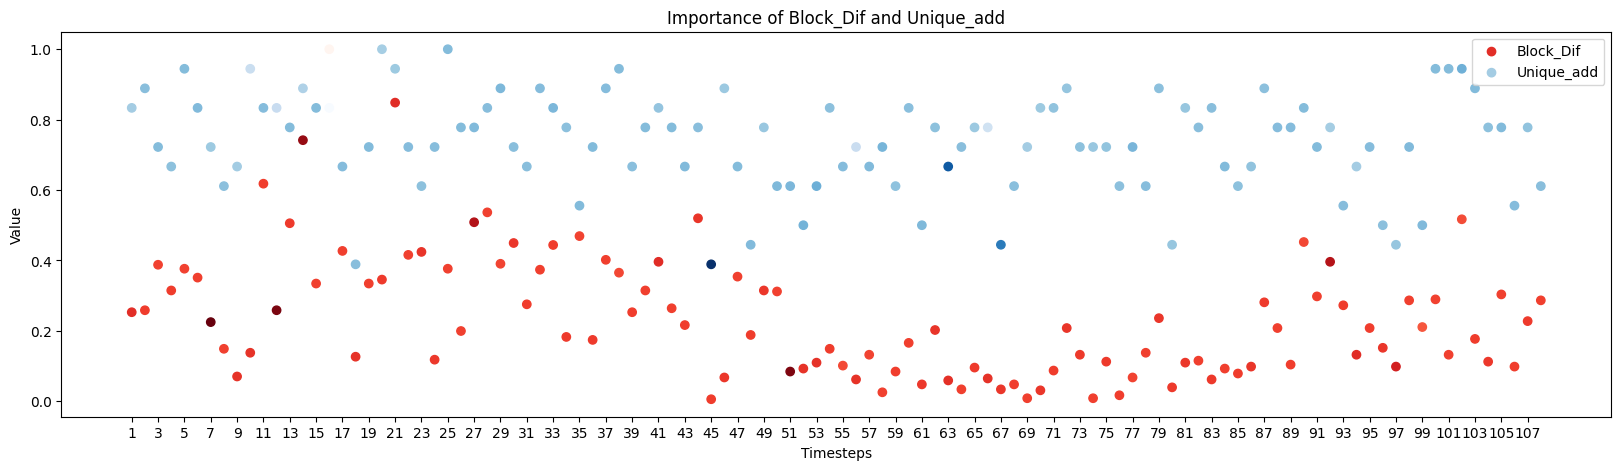

In [ ]:
scatter_feature2(eth_attr, X1_test[index].cpu().numpy(), 'Block_Dif', 'Unique_add')

In [ ]:
eth_agg = eth_aggregated_values(eth_attr)

In [ ]:
sent_agg = sent_aggregated_values(sent_attr)

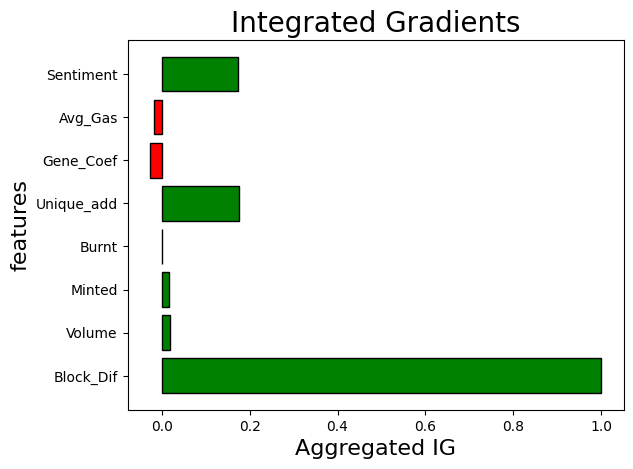

In [ ]:
plot_features(eth_agg, sent_agg)

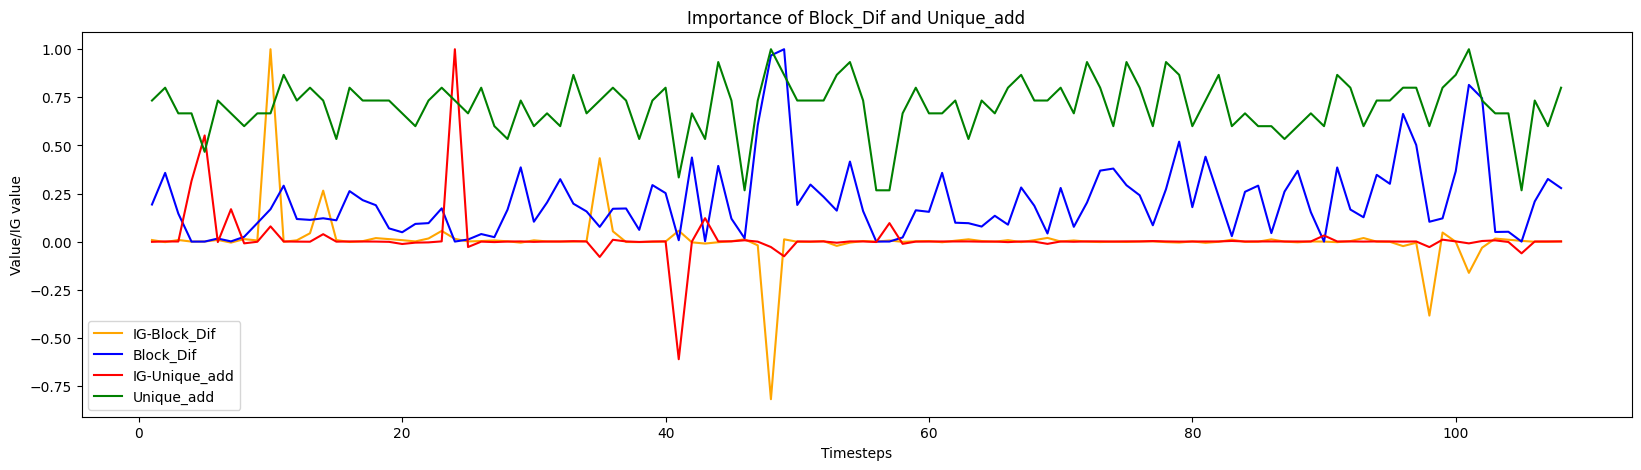

In [ ]:
line_plot2(eth_attr, X1_test[pos_index].cpu().numpy(), 'Block_Dif','Unique_add')

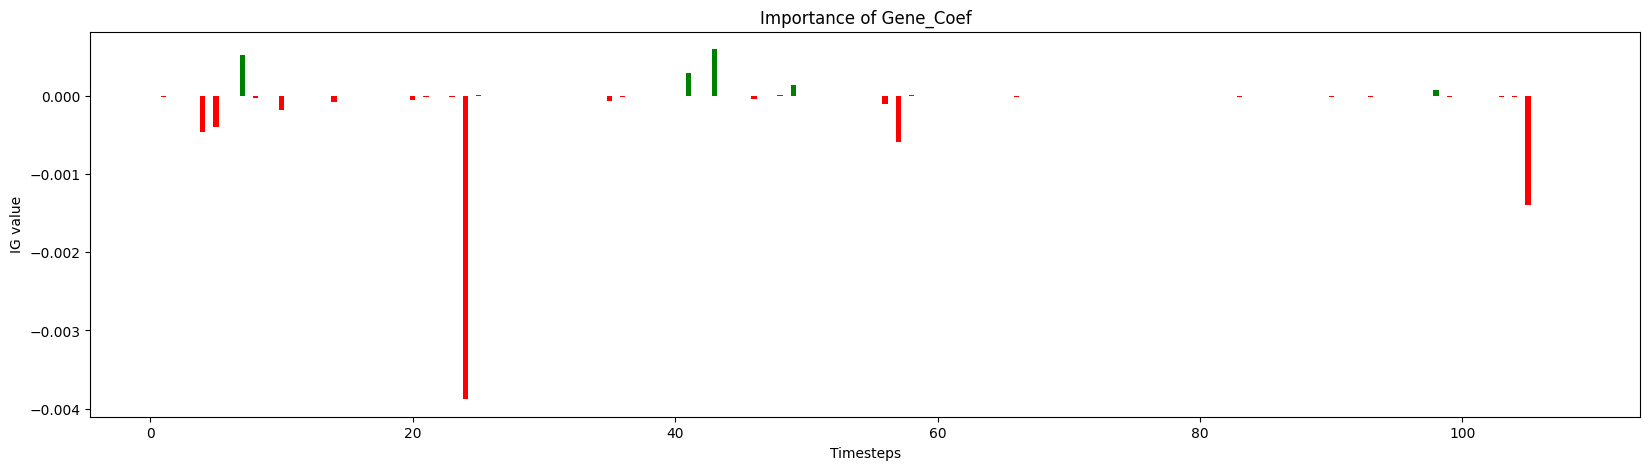

In [ ]:
plot_timeline(eth_attr, 'Gene_Coef')

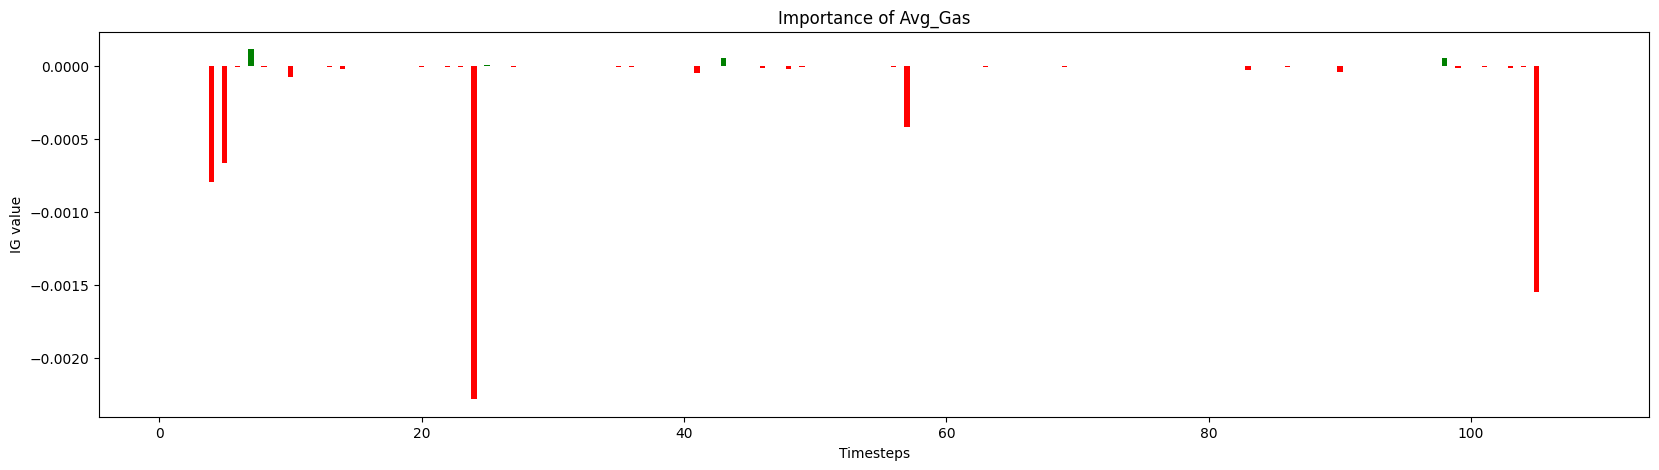

In [ ]:
plot_timeline(eth_attr, 'Avg_Gas')

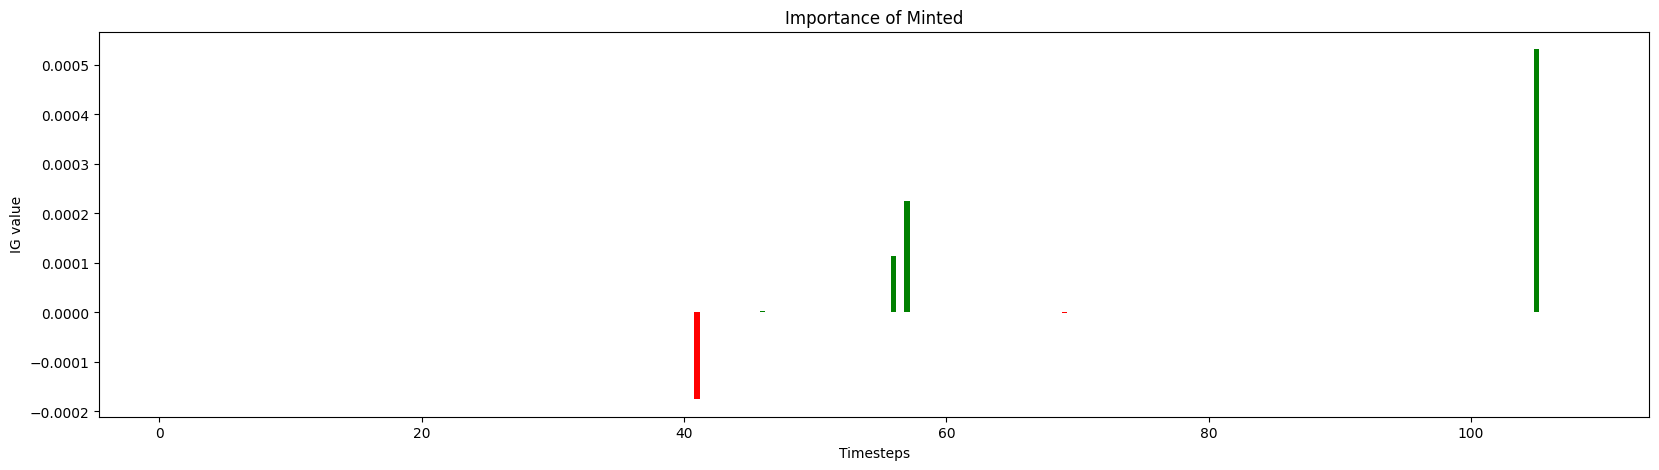

In [ ]:
plot_timeline(eth_attr, 'Minted')

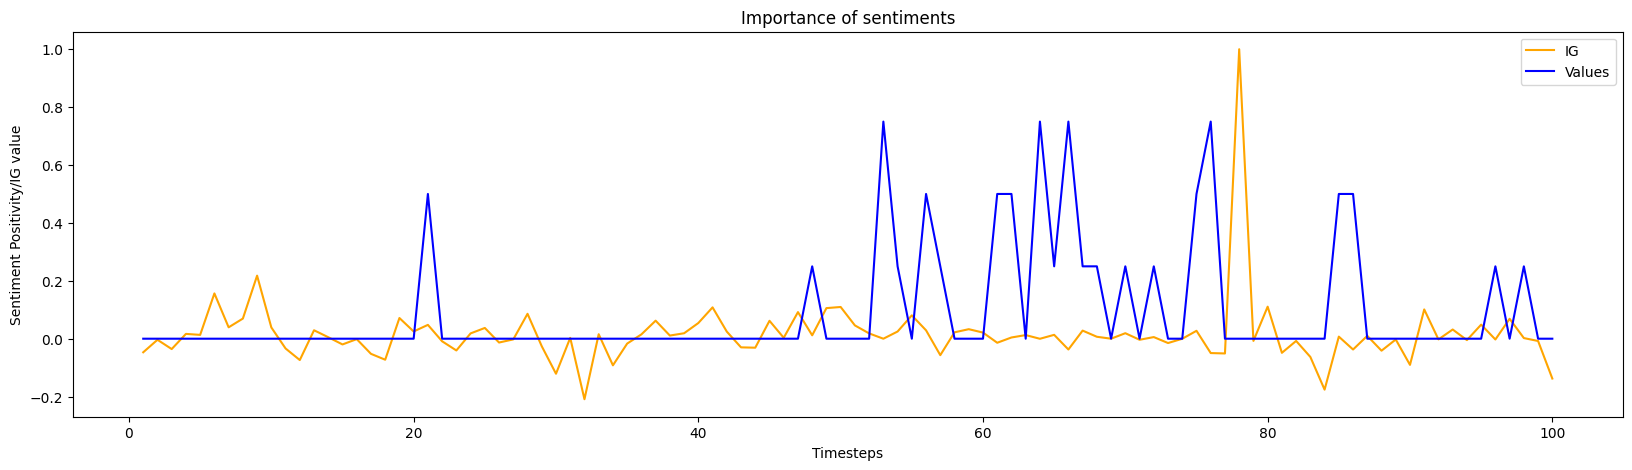

In [ ]:
plot_sentiment_timeline(sent_attr, X2_test[pos_index].cpu().numpy())

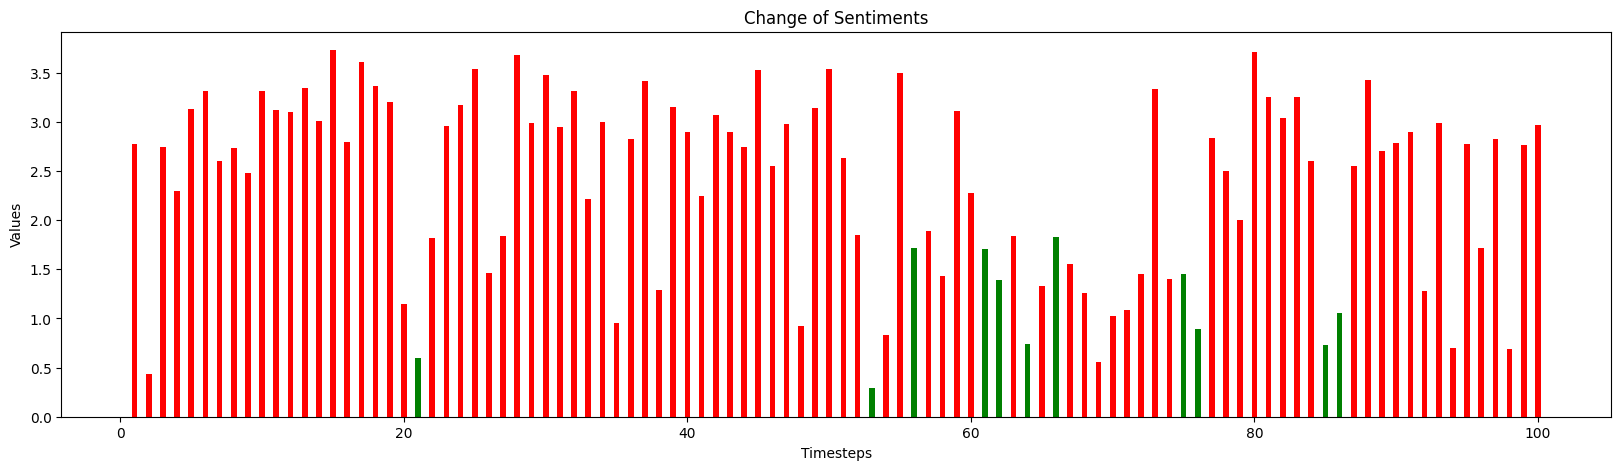

In [ ]:
plot_sentiment_vals(X2_test[pos_index].cpu().numpy())

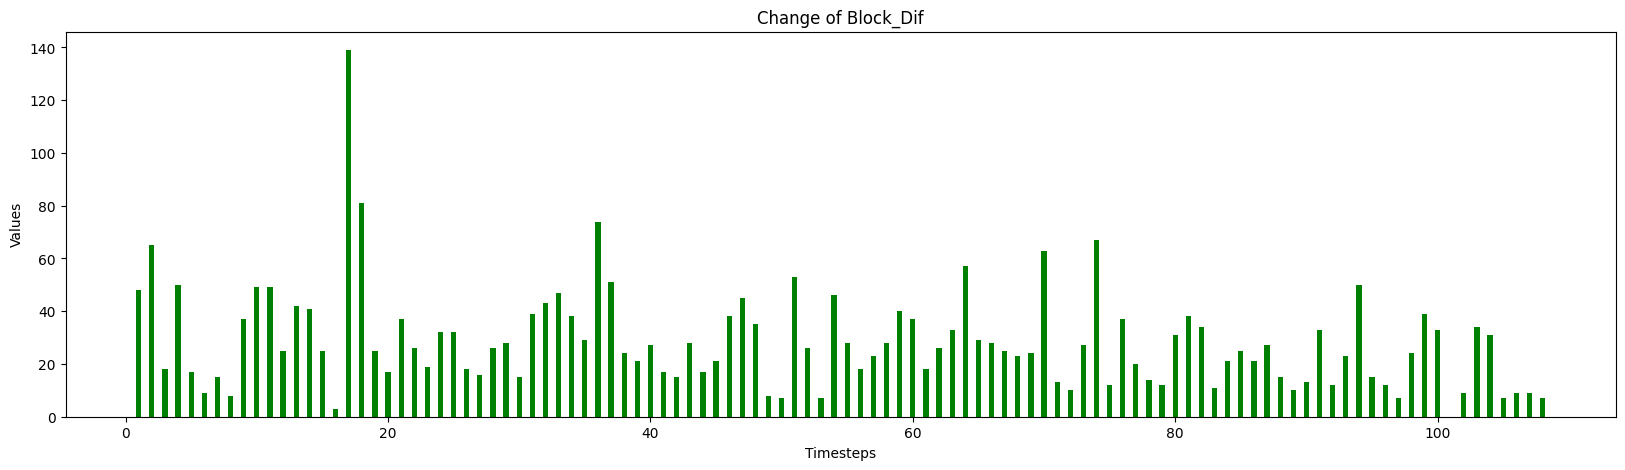

In [ ]:
plot_val_timeline(X1_test[pos_index].cpu().numpy(), 'Block_Dif')

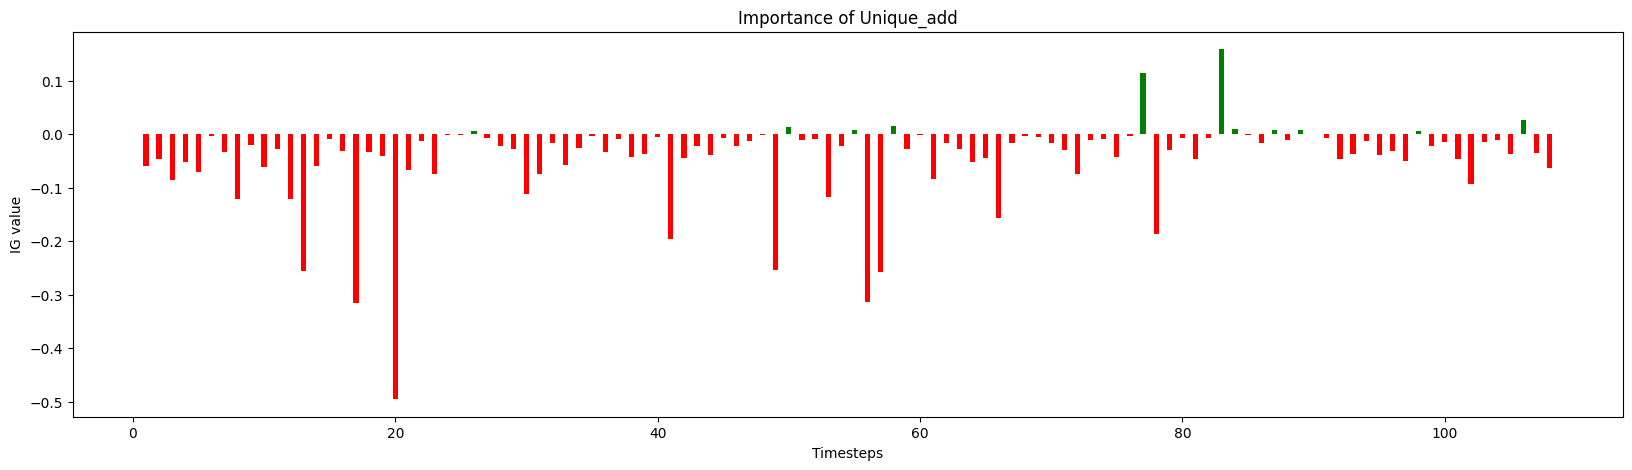

In [ ]:
plot_timeline(eth_attr, 'Unique_add')

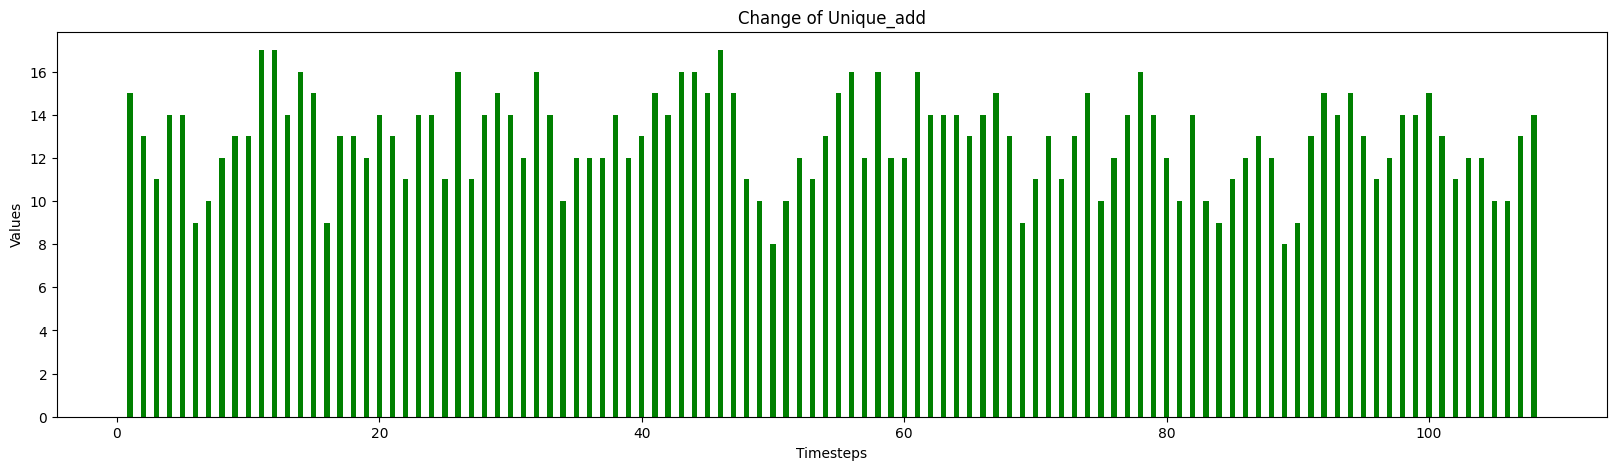

In [ ]:
plot_val_timeline(X1_test[pos_index].cpu().numpy(), 'Unique_add')

**Automate Plots**

In [ ]:
!pwd

/content/drive/MyDrive/FYP_Data/Latest


In [ ]:
def save_plot_features(attr, sent, path, name):
  attr.append(sent)
  attr = list(map(lambda x: x/abs(max(attr, key=abs)), attr))
  features = ['Block_Dif', 'Volume', 'Minted', 'Burnt', 'Unique_add', 'Gene_Coef', 'Avg_Gas', 'Sentiment']
  pos = np.arange(len(features))
  colors = ['g' if e >= 0 else 'r' for e in attr]

  plt.barh(pos,attr,color=colors,edgecolor='black')
  plt.yticks(pos, features)
  plt.xlabel('Aggregated IG', fontsize=16)
  plt.ylabel('features', fontsize=16)
  plt.title('Integrated Gradients',fontsize=20)
  #plt.savefig('./plots_ig/scam/foo'+'.png', bbox_inches='tight')
  plt.savefig(path+name+'.png', bbox_inches='tight')
  plt.clf()

In [ ]:
def get_prediction(x1, x2):
  sigmoid = nn.Sigmoid()
  x1 = torch.reshape(x1, (1, x1.shape[0], x1.shape[1]))
  x2 = torch.reshape(x2, (1, x2.shape[0], x2.shape[1]))
  val = sigmoid(loaded_model(x1.float(), x2.float()))
  return val

In [ ]:
for ind in range(X1_test.shape[0]):
  pred = get_prediction(X1_test[ind], X2_test[ind])
  print(f"{ind} : {float(pred[0][0])}")
  eth_attr, sent_attr = generate_ig(X1_test[ind], X2_test[ind])
  eth_agg = eth_aggregated_values(eth_attr)
  sent_agg = sent_aggregated_values(sent_attr)

  if (pred[0][0]>=0.5):
    save_plot_features(eth_agg, sent_agg, './plots_ig/trustworthy/', str(ind))
  else:
    save_plot_features(eth_agg, sent_agg, './plots_ig/scam/', str(ind))

In [ ]:
float(X1_test[0][75][0].cpu().numpy())

0.0

In [ ]:
for ind in range(X1_test.shape[0]):
  if float(X1_test[ind][75][0].cpu().numpy())>0:
    print(ind)

1
2
28
81
118
123
136
174
230
246
257
293
315
324
411
481
487
524
545
565
574
588
591
636
671
713
757
770
834
862
879
895
896
914
935
947
952
968
969
1044
1056
1122
1123
1173
1192
1195
1196
1294
1301
1304
1380
1397
1425
1481
1488
1519
1543
1573
1592
1594
1609
1613
1663
1697
1756
1758
1789
1802
1809
1871
1879
1899
1928
1946
2008
2014
2025
2026
2030
2042
2058
2059
2085
2091
2097
2110
2112
2170
2223
2240
2255
2259
2278
2286
2306
2310
2348
2351
2357


In [ ]:
va = get_prediction(X1_test[0], X2_test[0])
if (va[0][0]>=0.5):
  print("yeah")
else:
  print('nah')

nah


In [ ]:
for i in range()

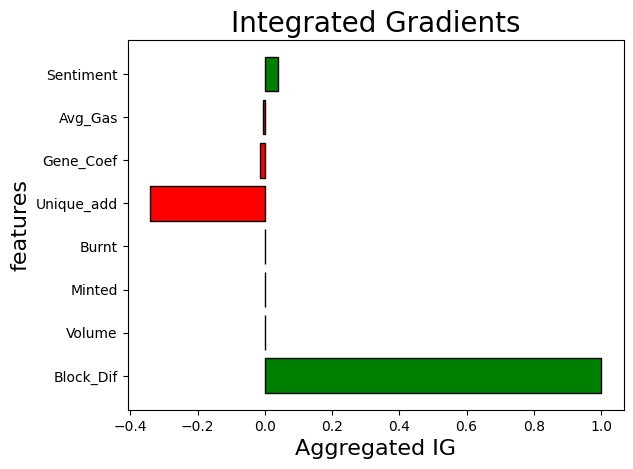

In [ ]:
save_plot_features(eth_agg, sent_agg)

Example tokens

In [ ]:
#ANUBIS DAO - First 850
ankh_x1 = np.load("ankh_x1.npy", allow_pickle=True)
ankh_x2 = np.load("ankh_x2.npy", allow_pickle=True)

In [ ]:
print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

print(ankh_x2.shape)
ankh_x2 = np.reshape(ankh_x2, (1, 100, 5))
print(ankh_x2.shape)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)


In [ ]:
ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)
ankh_x2 = torch.from_numpy(ankh_x2)
ankh_x2 = ankh_x2.to(device)

In [ ]:
sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float(), ankh_x2.float()))
print(val)
torch.round(val)

tensor([[0.0075]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#ANUBIS DAO - First 500
ankh_x1 = np.load("ankh_500_x1.npy", allow_pickle=True)
ankh_x2 = np.load("ankh_500_x2.npy", allow_pickle=True)

In [ ]:
print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

print(ankh_x2.shape)
ankh_x2 = np.reshape(ankh_x2, (1, 100, 5))
print(ankh_x2.shape)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)


In [ ]:
ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)
ankh_x2 = torch.from_numpy(ankh_x2)
ankh_x2 = ankh_x2.to(device)

In [ ]:
sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float(), ankh_x2.float()))
print(val)
torch.round(val)

tensor([[0.0018]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#ANUBIS DAO - First 750
ankh_x1 = np.load("ankh_750_x1.npy", allow_pickle=True)
ankh_x2 = np.load("ankh_750_x2.npy", allow_pickle=True)

In [ ]:
print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

print(ankh_x2.shape)
ankh_x2 = np.reshape(ankh_x2, (1, 100, 5))
print(ankh_x2.shape)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)


In [ ]:
ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)
ankh_x2 = torch.from_numpy(ankh_x2)
ankh_x2 = ankh_x2.to(device)

In [ ]:
sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float(), ankh_x2.float()))
print(val)
torch.round(val)

tensor([[0.0055]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#ANUBIS DAO - Full
ankh_x1 = np.load("ankh_full_x1.npy", allow_pickle=True)
ankh_x2 = np.load("ankh_full_x2.npy", allow_pickle=True)

In [ ]:
print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

print(ankh_x2.shape)
ankh_x2 = np.reshape(ankh_x2, (1, 100, 5))
print(ankh_x2.shape)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)


In [ ]:
ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)
ankh_x2 = torch.from_numpy(ankh_x2)
ankh_x2 = ankh_x2.to(device)

In [ ]:
sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float(), ankh_x2.float()))
print(val)
torch.round(val)

tensor([[0.0002]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#ANUBIS DAO - 750 with reviews

In [ ]:
ankh_x1 = np.load("ankh_750_x1.npy", allow_pickle=True)
ankh_x2 = np.load("ankh_encoded.npy", allow_pickle=True)

In [ ]:
print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

print(ankh_x2.shape)
ankh_x2 = np.reshape(ankh_x2, (1, 100, 5))
print(ankh_x2.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)
ankh_x2 = torch.from_numpy(ankh_x2)
ankh_x2 = ankh_x2.to(device)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)


In [ ]:
sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float(), ankh_x2.float()))
print(val)
torch.round(val)

tensor([[0.0056]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#ANUBIS DAO - Full with reviews

In [ ]:
ankh_x1 = np.load("ankh_full_x1.npy", allow_pickle=True)
ankh_x2 = np.load("ankh_encoded.npy", allow_pickle=True)

In [ ]:
print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

print(ankh_x2.shape)
ankh_x2 = np.reshape(ankh_x2, (1, 100, 5))
print(ankh_x2.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)
ankh_x2 = torch.from_numpy(ankh_x2)
ankh_x2 = ankh_x2.to(device)

In [ ]:
sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float(), ankh_x2.float()))
print(val)
torch.round(val)

tensor([[0.0002]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Sushi - First 500
sushi_x1 = np.load("sushi_500_x1.npy", allow_pickle=True)
sushi_x2 = np.load("sushi_500_x2.npy", allow_pickle=True)

In [ ]:
print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

print(sushi_x2.shape)
sushi_x2 = np.reshape(sushi_x2, (1, 100, 5))
print(sushi_x2.shape)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)


In [ ]:
sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)
sushi_x2 = torch.from_numpy(sushi_x2)
sushi_x2 = sushi_x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float(), sushi_x2.float()))
print(val)
torch.round(val)

tensor([[0.2806]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Sushi - First 750
sushi_x1 = np.load("sushi_750_x1.npy", allow_pickle=True)
sushi_x2 = np.load("sushi_750_x2.npy", allow_pickle=True)

In [ ]:
print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

print(sushi_x2.shape)
sushi_x2 = np.reshape(sushi_x2, (1, 100, 5))
print(sushi_x2.shape)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)


In [ ]:
sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)
sushi_x2 = torch.from_numpy(sushi_x2)
sushi_x2 = sushi_x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float(), sushi_x2.float()))
print(val)
torch.round(val)

tensor([[0.5763]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Sushi - Only eth
sushi_x1 = np.load("sushi_eth_x1.npy", allow_pickle=True)
sushi_x2 = np.load("sushi_eth_x2.npy", allow_pickle=True)

In [ ]:
print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

print(sushi_x2.shape)
sushi_x2 = np.reshape(sushi_x2, (1, 100, 5))
print(sushi_x2.shape)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)


In [ ]:
sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)
sushi_x2 = torch.from_numpy(sushi_x2)
sushi_x2 = sushi_x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float(), sushi_x2.float()))
print(val)
torch.round(val)

tensor([[0.9378]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Sushi - with reddit
sushi_x1 = np.load("sushi_full_x1.npy", allow_pickle=True)
sushi_x2 = np.load("sushi_full_x2.npy", allow_pickle=True)

In [ ]:
print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

print(sushi_x2.shape)
sushi_x2 = np.reshape(sushi_x2, (1, 100, 5))
print(sushi_x2.shape)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)


In [ ]:
sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)
sushi_x2 = torch.from_numpy(sushi_x2)
sushi_x2 = sushi_x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float(), sushi_x2.float()))
print(val)
torch.round(val)

tensor([[0.9364]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Sushi - with reddit part
sushi_x1 = np.load("sushi_full_x1.npy", allow_pickle=True)
sushi_x2 = np.load("sushi_full_x2.npy", allow_pickle=True)

In [ ]:
#850

for i in range(85,108):
  sushi_x1[i] = [0,0,0,0,0,0,0]
for j in range(80,100):
  sushi_x2[j] = [0,0,0,0,0]

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

print(sushi_x2.shape)
sushi_x2 = np.reshape(sushi_x2, (1, 100, 5))
print(sushi_x2.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)
sushi_x2 = torch.from_numpy(sushi_x2)
sushi_x2 = sushi_x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float(), sushi_x2.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)
tensor([[0.6520]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#500

for i in range(50,108):
  sushi_x1[i] = [0,0,0,0,0,0,0]
for j in range(50,100):
  sushi_x2[j] = [0,0,0,0,0]

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

print(sushi_x2.shape)
sushi_x2 = np.reshape(sushi_x2, (1, 100, 5))
print(sushi_x2.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)
sushi_x2 = torch.from_numpy(sushi_x2)
sushi_x2 = sushi_x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float(), sushi_x2.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)
tensor([[0.2852]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#750

for i in range(75,108):
  sushi_x1[i] = [0,0,0,0,0,0,0]
for j in range(75,100):
  sushi_x2[j] = [0,0,0,0,0]

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

print(sushi_x2.shape)
sushi_x2 = np.reshape(sushi_x2, (1, 100, 5))
print(sushi_x2.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)
sushi_x2 = torch.from_numpy(sushi_x2)
sushi_x2 = sushi_x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float(), sushi_x2.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)
tensor([[0.5792]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Anubis - with reddit part
ankh_x1 = np.load("ankh_full_x1.npy", allow_pickle=True)
ankh_x2 = np.load("ankh_encoded.npy", allow_pickle=True)

In [ ]:
#500

for i in range(50,108):
  ankh_x1[i] = [0,0,0,0,0,0,0]
for j in range(50,100):
  ankh_x2[j] = [0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

print(ankh_x2.shape)
ankh_x2 = np.reshape(ankh_x2, (1, 100, 5))
print(ankh_x2.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)
ankh_x2 = torch.from_numpy(ankh_x2)
ankh_x2 = ankh_x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float(), ankh_x2.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)
tensor([[0.0012]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#750

for i in range(75,108):
  ankh_x1[i] = [0,0,0,0,0,0,0]
for j in range(75,100):
  ankh_x2[j] = [0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

print(ankh_x2.shape)
ankh_x2 = np.reshape(ankh_x2, (1, 100, 5))
print(ankh_x2.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)
ankh_x2 = torch.from_numpy(ankh_x2)
ankh_x2 = ankh_x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float(), ankh_x2.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)
tensor([[0.0042]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#850

for i in range(85,108):
  ankh_x1[i] = [0,0,0,0,0,0,0]
for j in range(80,100):
  ankh_x2[j] = [0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

print(ankh_x2.shape)
ankh_x2 = np.reshape(ankh_x2, (1, 100, 5))
print(ankh_x2.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)
ankh_x2 = torch.from_numpy(ankh_x2)
ankh_x2 = ankh_x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float(), ankh_x2.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)
tensor([[0.0068]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving ape_full_x1.npy to ape_full_x1.npy
Saving ape_full_x2.npy to ape_full_x2.npy


**APE**

In [ ]:
x1 = np.load("ape_full_x1.npy", allow_pickle=True)
x2 = np.load("ape_full_x2.npy", allow_pickle=True)

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

print(x2.shape)
x2 = np.reshape(x2, (1, 100, 5))
print(x2.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)
x2 = torch.from_numpy(x2)
x2 = x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float(), x2.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)
tensor([[6.5108e-05]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
x1 = np.load("ape_full_x1.npy", allow_pickle=True)
x2 = np.load("ape_full_x2.npy", allow_pickle=True)

#500
for i in range(50,108):
  x1[i] = [0,0,0,0,0,0,0]
for j in range(50,100):
  x2[j] = [0,0,0,0,0]

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

print(x2.shape)
x2 = np.reshape(x2, (1, 100, 5))
print(x2.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)
x2 = torch.from_numpy(x2)
x2 = x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float(), x2.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)
tensor([[0.0028]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
x1 = np.load("ape_full_x1.npy", allow_pickle=True)
x2 = np.load("ape_full_x2.npy", allow_pickle=True)

#750
for i in range(75,108):
  x1[i] = [0,0,0,0,0,0,0]
for j in range(75,100):
  x2[j] = [0,0,0,0,0]

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

print(x2.shape)
x2 = np.reshape(x2, (1, 100, 5))
print(x2.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)
x2 = torch.from_numpy(x2)
x2 = x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float(), x2.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)
tensor([[0.0107]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
x1 = np.load("ape_full_x1.npy", allow_pickle=True)
x2 = np.load("ape_full_x2.npy", allow_pickle=True)

#850
for i in range(85,108):
  x1[i] = [0,0,0,0,0,0,0]
for j in range(80,100):
  x2[j] = [0,0,0,0,0]

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

print(x2.shape)
x2 = np.reshape(x2, (1, 100, 5))
print(x2.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)
x2 = torch.from_numpy(x2)
x2 = x2.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float(), x2.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
(100, 5)
(1, 100, 5)
tensor([[0.0113]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)